In [336]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
import requests
import json
from urllib.parse import urlencode
warnings.filterwarnings("ignore")

In [337]:
pd.read_excel("sa.xlsx")

,_date_,t_fesa
0,2006-01-01,122.629907
1,2006-02-01,123.144350
2,2006-03-01,123.674721
3,2006-04-01,124.921133
4,2006-05-01,127.781905
...,...,...
219,2024-04-01,2191.381124
220,2024-05-01,2274.408266
221,2024-06-01,2325.311950
222,2024-07-01,2406.771700


In [338]:
sa=pd.read_excel("sa.xlsx")
sa=pd.DataFrame(sa["t_fesa"].dropna())
sa=sa.set_index(pd.date_range(start="2006-01-30",periods=len(sa),freq="M"))
sa.columns=["TÜFE"]
sa["Enflasyon"]=sa["TÜFE"].pct_change()*100
sa=sa.dropna()
sa["3 Aylık MA"]=sa["Enflasyon"].rolling(3).mean()
sa

,TÜFE,Enflasyon,3 Aylık MA
2006-02-28,123.144350,0.419508,NaN
2006-03-31,123.674721,0.430691,NaN
2006-04-30,124.921133,1.007814,0.619338
2006-05-31,127.781905,2.290063,1.242856
2006-06-30,128.963983,0.925075,1.407651
...,...,...,...
2024-04-30,2191.381124,2.844822,3.635659
2024-05-31,2274.408266,3.788804,3.318979
2024-06-30,2325.311950,2.238107,2.957244
2024-07-31,2406.771700,3.503175,3.176695


In [339]:
100*(((1+(sa["3 Aylık MA"].tail(7)/100))**12)-1)

2024-02-29    69.220274
2024-03-31    70.863757
2024-04-30    53.500764
2024-05-31    47.965776
2024-06-30    41.867502
2024-07-31    45.538993
2024-08-31    40.638050
Freq: ME, Name: 3 Aylık MA, dtype: float64

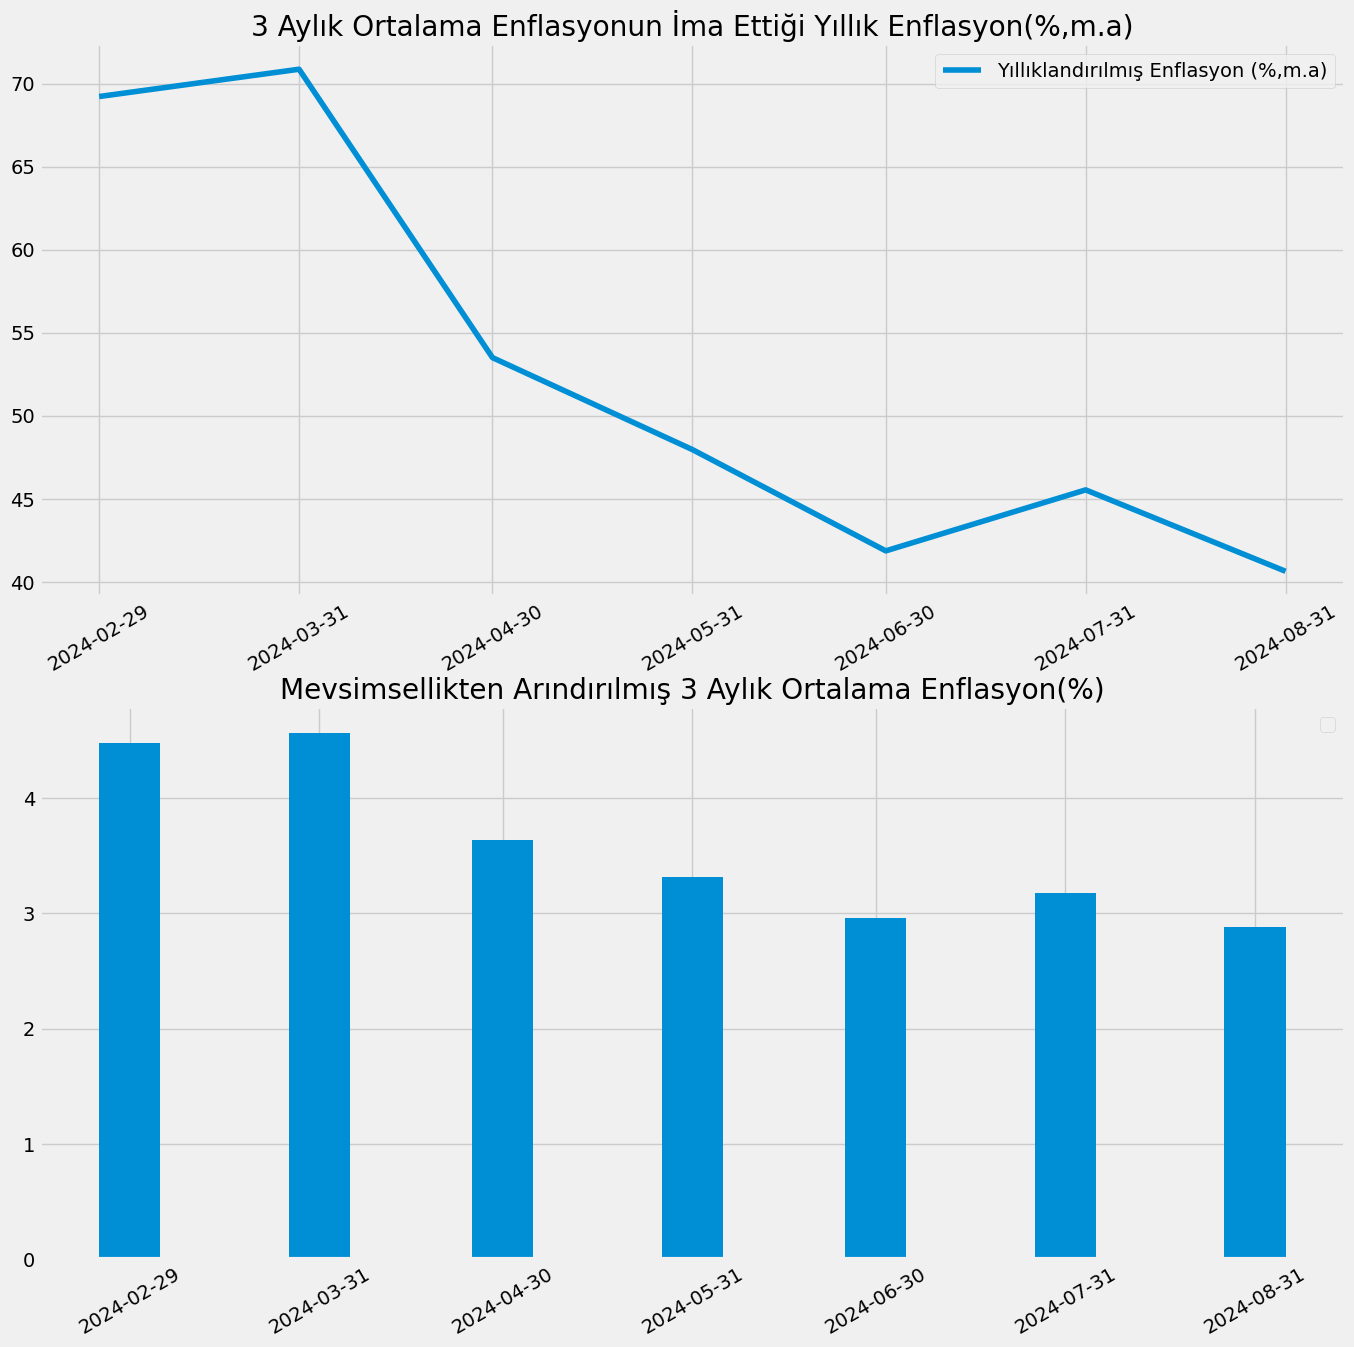

In [340]:
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.title("3 Aylık Ortalama Enflasyonun İma Ettiği Yıllık Enflasyon(%,m.a)")
plt.plot(100*(((1+(sa["3 Aylık MA"].tail(7)/100))**12)-1),label="Yıllıklandırılmış Enflasyon (%,m.a)")
plt.xticks(sa.tail(7).index,rotation=30)
plt.legend()
plt.subplot(2,1,2)
plt.title("Mevsimsellikten Arındırılmış 3 Aylık Ortalama Enflasyon(%)")
plt.bar(height=sa["3 Aylık MA"].tail(7),x=sa.tail(7).index,width=10)
plt.xticks(sa.tail(7).index,rotation=30)
plt.legend()

In [341]:
with open("C:/Users/Bora/Desktop/api.txt") as api:
    key=api.read()



In [342]:
import yfinance as yf 


In [343]:
params = {
    'series': "TP.DK.USD.S.YTL",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

usd = formatted_response['items']
usd = pd.DataFrame(usd)


usd = usd.drop(columns=['UNIXTIME','Tarih'])
usd.columns = ['USD/TL']
usd['USD/TL'] = pd.to_numeric(usd['USD/TL'])
usd=usd.set_index(pd.date_range(start="2006-01-01",freq="D",periods=len(usd)))
usd=usd.dropna()
usd

,USD/TL
2006-01-02,1.3483
2006-01-03,1.3506
2006-01-04,1.3484
2006-01-05,1.3381
2006-01-06,1.3362
...,...
2024-08-05,33.1359
2024-08-06,33.3172
2024-08-07,33.4586
2024-08-08,33.5568


In [344]:
params = {
    'series': "TP.FE.OKTG01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf = formatted_response['items']
enf = pd.DataFrame(enf)


enf = enf.drop(columns=['UNIXTIME','Tarih'])
enf.columns = ['TÜFE']
enf['TÜFE'] = pd.to_numeric(enf['TÜFE'])
enf=enf.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf)))
enf

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2024-03-31,2139.47
2024-04-30,2207.50
2024-05-31,2281.85
2024-06-30,2319.29


In [345]:
params = {
    'series': "TP.PR.ARZ13",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

money = formatted_response['items']
money = pd.DataFrame(money)


money = money.drop(columns=['UNIXTIME','Tarih'])
money.columns = ['Para Arzi']
money['Para Arzi'] = pd.to_numeric(money['Para Arzi'])
money=money.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(money)))
money=money.pct_change()*100
money=money.dropna()
money

,Para Arzi
2006-02-28,2.121748
2006-03-31,2.927613
2006-04-30,1.084694
2006-05-31,9.121170
2006-06-30,1.433197
...,...
2024-04-30,1.982216
2024-05-31,1.859475
2024-06-30,3.106859
2024-07-31,2.462723


In [346]:
params = {
    'series': "TP.PR.ARZ22",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m3 = formatted_response['items']
m3 = pd.DataFrame(m3)


m3 = m3.drop(columns=['UNIXTIME','YEARWEEK'])
m3.columns = ['Tarih','M3']
m3['M3'] = pd.to_numeric(m3['M3'])
m3 = m3.set_index(pd.to_datetime(m3["Tarih"], format="%d-%m-%Y"))
del m3["Tarih"]
m3=m3.pct_change(4)*100
m3=m3.resample('M').last()
m3=m3.dropna()
m3

,M3
Tarih,
2006-02-28,2.204708
2006-03-31,2.711175
2006-04-30,1.323922
2006-05-31,9.308200
2006-06-30,-0.288618
...,...
2024-04-30,2.405048
2024-05-31,3.570039
2024-06-30,2.937087


In [347]:
params = {
    'series': "TP.PR.ARZ01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m1 = formatted_response['items']
m1 = pd.DataFrame(m1)


m1 = m1.drop(columns=['UNIXTIME','YEARWEEK'])
m1.columns = ['Tarih','M1']
m1['M1'] = pd.to_numeric(m1['M1'])
m1 = m1.set_index(pd.to_datetime(m1["Tarih"], format="%d-%m-%Y"))
del m1["Tarih"]
m1=m1.pct_change(4)*100
m1=m1.resample('M').last()
m1=m1.dropna()
m1

,M1
Tarih,
2006-02-28,4.504977
2006-03-31,5.085533
2006-04-30,3.473587
2006-05-31,10.905356
2006-06-30,-0.497357
...,...
2024-04-30,-1.148379
2024-05-31,0.857734
2024-06-30,2.584482


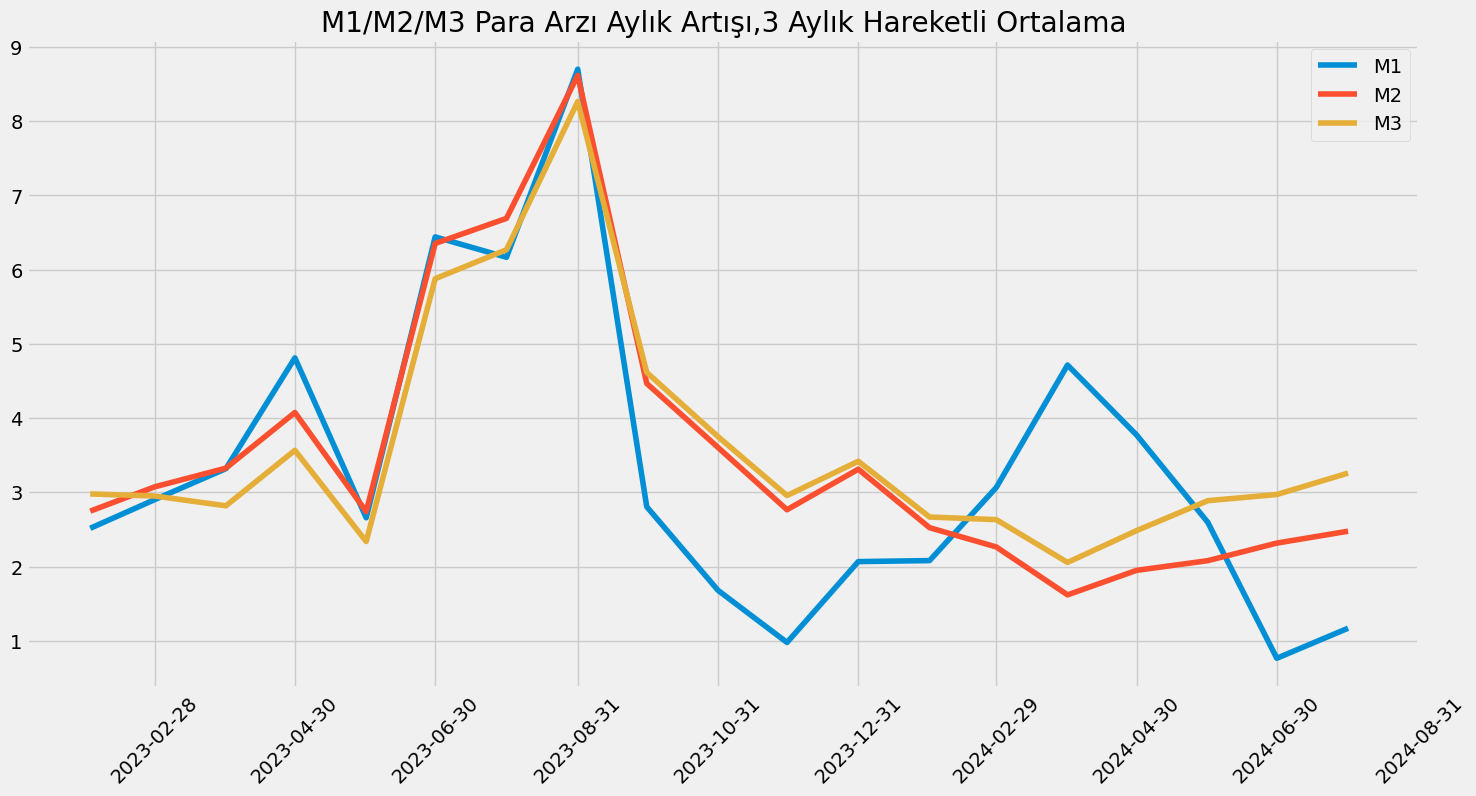

In [348]:
plt.figure(figsize=(16,8))
plt.title("M1/M2/M3 Para Arzı Aylık Artışı,3 Aylık Hareketli Ortalama")
plt.plot(m1.rolling(3).mean().iloc[:-1].tail(19),label="M1")
plt.plot(money.rolling(3).mean().iloc[:-1].tail(19),label="M2")
plt.plot(m3.rolling(3).mean().iloc[:-1].tail(19),label="M3")
plt.xticks(money.tail(19).index[::2],rotation=45)
plt.legend()


In [349]:
params = {
    'series': "TP.TIG08",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

issizlik = formatted_response['items']
issizlik = pd.DataFrame(issizlik)


issizlik = issizlik.drop(columns=['UNIXTIME','Tarih'])
issizlik.columns = ['İşsizlik']
issizlik['İşsizlik'] = pd.to_numeric(issizlik['İşsizlik'])
issizlik=issizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(issizlik)))
issizlik=issizlik.dropna()
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2024-01-31,9.0
2024-02-29,8.7
2024-03-31,8.6
2024-04-30,8.5


In [350]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2024-04-30,88.999999
2024-05-31,82.991819
2024-06-30,82.889474


In [351]:
params = {
    'series': "TP.KREDI.L001",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

kredi = formatted_response['items']
kredi = pd.DataFrame(kredi)


kredi = kredi.drop(columns=['UNIXTIME','YEARWEEK'])
kredi.columns = ['Tarih','Kredi']
kredi['Kredi'] = pd.to_numeric(kredi['Kredi'])
kredi = kredi.set_index(pd.to_datetime(kredi["Tarih"], format="%d-%m-%Y"))
del kredi["Tarih"]
kredi=kredi.pct_change(4)*100
kredi=kredi.resample('M').last()
kredi=kredi.dropna()
kredi

,Kredi
Tarih,
2006-02-28,1.559036
2006-03-31,5.768193
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.965727
...,...
2024-04-30,1.832087
2024-05-31,2.996833
2024-06-30,2.281882


In [352]:
params = {
    'series': "TP.APIFON4",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

pfaiz = formatted_response['items']
pfaiz = pd.DataFrame(pfaiz)


pfaiz = pfaiz.drop(columns=['UNIXTIME','Tarih'])
pfaiz.columns = ['Faiz']
pfaiz['Faiz'] = pd.to_numeric(pfaiz['Faiz'])
pfaiz=pfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(pfaiz)))
pfaiz=pfaiz.dropna()
pfaiz

,Faiz
2011-01-31,6.438571
2011-02-28,6.250000
2011-03-31,6.250000
2011-04-30,6.267619
2011-05-31,6.250000
...,...
2024-04-30,51.357222
2024-05-31,50.544545
2024-06-30,50.106471
2024-07-31,50.000000


In [353]:
motorin=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar.xls")
motorin=motorin.iloc[-1,:]
motorin=pd.DataFrame(motorin[3:])
motorin=motorin.set_index(pd.date_range(start="2005-01-31",periods=len(motorin),freq="M"))
motorin.columns=["Motorin"]
motorin

,Motorin
2005-01-31,1.75
2005-02-28,1.78
2005-03-31,1.87
2005-04-30,1.94
2005-05-31,1.88
...,...
2024-02-29,43.0968
2024-03-31,42.0568
2024-04-30,42.6763
2024-05-31,41.2854


In [354]:
params = {
    'series': "TP.TRY.MT02",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

mfaiz = formatted_response['items']
mfaiz = pd.DataFrame(mfaiz)


mfaiz = mfaiz.drop(columns=['UNIXTIME','Tarih'])
mfaiz.columns = ['Mevduat Faizi']
mfaiz['Mevduat Faizi'] = pd.to_numeric(mfaiz['Mevduat Faizi'])
mfaiz=mfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(mfaiz)))
mfaiz=mfaiz.dropna()
mfaiz

,Mevduat Faizi
2006-01-31,15.913333
2006-02-28,15.760000
2006-03-31,15.330000
2006-04-30,15.175000
2006-05-31,14.925000
...,...
2024-04-30,67.567500
2024-05-31,64.538000
2024-06-30,59.695000
2024-07-31,59.382500


In [355]:
params = {
    'series': "TP.BEK.S01.A.S",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf_belirsizlik = formatted_response['items']
enf_belirsizlik = pd.DataFrame(enf_belirsizlik)


enf_belirsizlik = enf_belirsizlik.drop(columns=['UNIXTIME','Tarih'])
enf_belirsizlik.columns = ['Enflasyon Belirsizliği']
enf_belirsizlik['Enflasyon Belirsizliği'] = pd.to_numeric(enf_belirsizlik['Enflasyon Belirsizliği'])
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf_belirsizlik)))
enf_belirsizlik=enf_belirsizlik.dropna()
enf_belirsizlik

,Enflasyon Belirsizliği
2013-01-31,0.32
2013-02-28,0.22
2013-03-31,0.16
2013-04-30,0.26
2013-05-31,0.29
...,...
2024-03-31,0.64
2024-04-30,0.55
2024-05-31,0.47
2024-06-30,0.48


In [356]:
params = {
    'series': "TP.FG.B01.95",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ito = formatted_response['items']
ito = pd.DataFrame(ito)


ito = ito.drop(columns=['UNIXTIME','Tarih'])
ito.columns = ['İTO']
ito['İTO'] = pd.to_numeric(ito['İTO'])
ito=ito.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ito)))
ito=ito.pct_change()*100
ito=ito.dropna()
ito

,İTO
2006-02-28,1.005528
2006-03-31,0.137253
2006-04-30,2.088936
2006-05-31,1.595826
2006-06-30,-0.100368
...,...
2024-03-31,3.926249
2024-04-30,4.894259
2024-05-31,3.589407
2024-06-30,3.420697


In [357]:
params = {
    'series': "TP.FE.OKTG04",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

tufec = formatted_response['items']
tufec = pd.DataFrame(tufec)


tufec = tufec.drop(columns=['UNIXTIME','Tarih'])
tufec.columns = ['TÜFE C']
tufec['TÜFE C'] = pd.to_numeric(tufec['TÜFE C'])
tufec=tufec.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(tufec)))
tufec=tufec.pct_change()*100
tufec=tufec.shift(1)
tufec=tufec.dropna()
tufec

,TÜFE C
2006-03-31,-1.101304
2006-04-30,-0.368460
2006-05-31,1.857331
2006-06-30,2.622237
2006-07-31,1.344445
...,...
2024-03-31,3.571725
2024-04-30,3.524351
2024-05-31,3.562117
2024-06-30,3.760332


In [358]:
params = {
    'series': "TP.TUFE1YI.T1",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

üfe = formatted_response['items']
üfe = pd.DataFrame(üfe)


üfe = üfe.drop(columns=['UNIXTIME','Tarih'])
üfe.columns = ['ÜFE']
üfe['ÜFE'] = pd.to_numeric(üfe['ÜFE'])
üfe=üfe.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(üfe)))
üfe=üfe.pct_change()*100
üfe=üfe.dropna()
üfe

,ÜFE
2006-02-28,0.256616
2006-03-31,0.247960
2006-04-30,1.938881
2006-05-31,2.770820
2006-06-30,4.021325
...,...
2024-03-31,3.294983
2024-04-30,3.602753
2024-05-31,1.957875
2024-06-30,1.376326


In [359]:
params = {
    'series': "TP.IHRACATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ihracat = formatted_response['items']
ihracat = pd.DataFrame(ihracat)


ihracat = ihracat.drop(columns=['UNIXTIME','Tarih'])
ihracat.columns = ['ÜFE']
ihracat['ÜFE'] = pd.to_numeric(ihracat['ÜFE'])
ihracat=ihracat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ihracat)))
ihracat=ihracat.shift(1)
ihracat=ihracat.dropna()
ihracat=ihracat.pct_change()*100
ihracat

,ÜFE
2013-02-28,NaN
2013-03-31,7.272509
2013-04-30,6.926004
2013-05-31,-4.381315
2013-06-30,5.141469
...,...
2024-02-29,-12.998830
2024-03-31,5.577214
2024-04-30,7.448072
2024-05-31,-14.800676


In [360]:
params = {
    'series': "TP.ITHALATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ithalat = formatted_response['items']
ithalat = pd.DataFrame(ithalat)


ithalat = ithalat.drop(columns=['UNIXTIME','Tarih'])
ithalat.columns = ['ÜFE']
ithalat['ÜFE'] = pd.to_numeric(ithalat['ÜFE'])
ithalat=ithalat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ithalat)))
ithalat=ithalat.shift(1)
ithalat=ithalat.dropna()
ithalat=ithalat.pct_change()*100
ithalat

,ÜFE
2013-02-28,NaN
2013-03-31,3.993020
2013-04-30,4.802567
2013-05-31,11.093906
2013-06-30,0.635134
...,...
2024-02-29,-9.755527
2024-03-31,6.285140
2024-04-30,7.508824
2024-05-31,-2.530191


In [361]:
params = {
    'series': "TP.PKAUO.S01.A.U",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

anket = formatted_response['items']
anket = pd.DataFrame(anket)


anket = anket.drop(columns=['UNIXTIME','Tarih'])
anket.columns = ['ÜFE']
anket['ÜFE'] = pd.to_numeric(anket['ÜFE'])
anket=anket.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(anket)))
anket=anket.dropna()

anket

,ÜFE
2013-01-31,0.85
2013-02-28,0.53
2013-03-31,0.48
2013-04-30,0.65
2013-05-31,0.46
...,...
2024-03-31,3.43
2024-04-30,3.25
2024-05-31,3.04
2024-06-30,2.52


In [362]:
data=pd.DataFrame()
data["USD/TL"]=usd["USD/TL"].resample('M').mean().rolling(3).mean()
data["Motorin"]=motorin["Motorin"]
data["TÜFE"]=enf["TÜFE"]
data["TÜFEt-1"]=data["TÜFE"].shift(1)
data=data.pct_change()*100
data["M3"]=m3["M3"].shift(1)
data["ÜFEt1"]=üfe["ÜFE"].shift(1)
data["ÜFEt2"]=üfe["ÜFE"].shift(2)
data["TÜFECt1"]=tufec["TÜFE C"]
data["TÜFECt2"]=tufec["TÜFE C"].shift(1)
data["İTO"]=ito["İTO"]
data["İhracat"]=ihracat["ÜFE"]
data["İthalat"]=ithalat["ÜFE"]
data["Anket"]=anket["ÜFE"]
data

,USD/TL,Motorin,TÜFE,TÜFEt-1,M3,ÜFEt1,ÜFEt2,TÜFECt1,TÜFECt2,İTO,İhracat,İthalat,Anket
2006-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-28,NaN,0.000000,0.218500,NaN,NaN,NaN,NaN,NaN,NaN,1.005528,NaN,NaN,NaN
2006-03-31,NaN,0.975610,0.274548,0.218500,2.204708,0.256616,NaN,-1.101304,NaN,0.137253,NaN,NaN,NaN
2006-04-30,0.075089,2.898551,1.336769,0.274548,2.711175,0.247960,0.256616,-0.368460,-1.101304,2.088936,NaN,NaN,NaN
2006-05-31,2.353679,4.694836,1.875397,1.336769,1.323922,1.938881,0.247960,1.857331,-0.368460,1.595826,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,2.452282,1.473008,3.179759,3.162671,2.687835,3.294983,3.737000,3.524351,3.571725,4.894259,7.448072,7.508824,3.25
2024-05-31,1.565526,-3.259186,3.368063,3.179759,2.405048,3.602753,3.294983,3.562117,3.524351,3.589407,-14.800676,-2.530191,3.04
2024-06-30,0.553511,0.290660,1.640774,3.368063,3.570039,1.957875,3.602753,3.760332,3.562117,3.420697,25.376262,5.062170,2.52
2024-07-31,0.581912,0.000000,3.225556,1.640774,2.937087,1.376326,1.957875,1.727271,3.760332,4.207686,NaN,NaN,2.77


In [363]:

data["Kredi"]=kredi["Kredi"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["İşsizlik"]=issizlik["İşsizlik"]
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Faiz"]
data["Zam"]=0
data=data[['USD/TL', 'Motorin','M3', 'Enflasyon Belirsizliği','Zam','TÜFEt-1','ParaArzi','Kredi','İhracat','İthalat','Mevduat Faizi','Anket','İşsizlik','Politika Faizi','ÜFEt2','TÜFECt2','ÜFEt1','TÜFECt1','İTO','TÜFE']]
data.iloc[:12,4]=380.46
data.iloc[12:18,4]=403.03
data.iloc[18:24,4]=419.15
data.iloc[24:30,4]=481.55
data.iloc[30:36,4]=503.26
data.iloc[36:42,4]=527.13
data.iloc[42:48,4]=546.48
data.iloc[48:54,4]=576.57
data.iloc[54:60,4]=599.12
data.iloc[60:66,4]=629.96
data.iloc[66:72,4]=658.95
data.iloc[72:78,4]=701.13
data.iloc[78:84,4]=739.79
data.iloc[84:90,4]=773.01
data.iloc[90:96,4]=803.68
data.iloc[96:102,4]=846.00
data.iloc[102:108,4]=891.03
data.iloc[108:114,4]=949.07
data.iloc[114:120,4]=1000.54
data.iloc[120:132,4]=1300.99
data.iloc[132:144,4]=1404.06
data.iloc[144:156,4]=1603.12
data.iloc[156:168,4]=2020.9
data.iloc[168:180,4]=2324.71
data.iloc[180:192,4]=2825.90
data.iloc[192:198,4]=4253.4
data.iloc[198:204,4]=5500.35
data.iloc[204:210,4]=8506.8
data.iloc[210:216,4]=11402.33
data.iloc[216:,4]=17002
data["Zam"]=data["Zam"].pct_change()*100
data=data.fillna(0)
data["İşsizlik"].iloc[-2:]=8.4


data=data.loc["2014-01-31":]
data["TÜFE"].loc["2023-05-31"]+=2.88
data["ÜFEt1"].iloc[-1]=1.94
data["ÜFEt2"].iloc[-2:]=[1.9578,1.38]
data["TÜFECt1"].iloc[-1]=2.45
data["Motorin"].iloc[-2:]=[8.88,1.53]
data["TÜFECt2"].iloc[-1]=1.73
data["İhracat"].iloc[-2:]=[-22.87,21.23]
data["İthalat"].iloc[-2:]=[-18.27,18.96]
data["Enflasyon Belirsizliği"].iloc[-1]=0.50
data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Zam,TÜFEt-1,ParaArzi,Kredi,İhracat,İthalat,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,İTO,TÜFE
2014-01-31,3.732429,2.881984,3.413428,0.37,5.265777,0.460607,3.375162,2.886648,-7.844611,7.652883,9.0220,1.06,9.2,7.503636,0.618013,0.625859,1.106494,-0.111246,0.333618,1.978080
2014-02-28,3.033477,1.685899,1.958423,0.31,0.000000,1.978080,1.804994,2.214819,-6.175956,-14.641565,10.6275,0.69,9.5,10.070500,1.106494,-0.111246,3.319203,0.308798,1.009554,0.428192
2014-03-31,2.465778,-2.278097,0.229599,0.16,0.000000,0.428192,0.451349,1.160171,4.991889,-6.505852,11.3125,0.65,9.5,10.200952,3.319203,0.308798,1.383675,0.701489,0.989257,1.125608
2014-04-30,-1.344724,-6.214384,0.730196,0.23,0.000000,1.125608,0.796760,0.126575,12.575902,13.043316,11.0200,0.76,9.7,10.046190,1.383675,0.701489,0.736212,1.197755,2.649799,1.344970
2014-05-31,-1.859714,-0.561578,-0.093468,0.26,0.000000,1.344970,-0.362357,0.464970,-7.919312,0.662228,10.4940,0.63,9.7,9.891000,0.736212,1.197755,0.085477,2.119546,0.211698,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,2.452282,1.473008,2.687835,0.55,0.000000,3.162671,2.396667,3.023668,7.448072,7.508824,67.5675,3.25,8.5,51.357222,3.737000,3.571725,3.294983,3.524351,4.894259,3.179759
2024-05-31,1.565526,-3.259186,2.405048,0.47,0.000000,3.179759,1.982216,2.979193,-14.800676,-2.530191,64.5380,3.04,8.4,50.544545,3.294983,3.524351,3.602753,3.562117,3.589407,3.368063
2024-06-30,0.553511,0.290660,3.570039,0.48,0.000000,3.368063,1.859475,2.370267,25.376262,5.062170,59.6950,2.52,0.0,50.106471,3.602753,3.562117,1.957875,3.760332,3.420697,1.640774
2024-07-31,0.581912,8.880000,2.937087,0.60,0.000000,1.640774,3.106859,2.223247,-22.870000,-18.270000,59.3825,2.77,8.4,50.000000,1.957800,3.760332,1.376326,1.727271,4.207686,3.225556


In [364]:
data["ParaArzi"]=data["ParaArzi"].shift(-1).rolling(3).mean()


In [365]:
data["Motorin"]=data["Motorin"].rolling(2).mean()

In [366]:
data["Kredi"]=kredi["Kredi"].shift(1).rolling(2).mean()

In [367]:
data["ParaArzi"].iloc[-1]=1.81
data["Anket"].iloc[-1]=2.17

## Cari Ay Enflasyon Tahmini

In [369]:
data=data.dropna()

In [370]:
from sklearn.model_selection import train_test_split
features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'Zam', 'TÜFEt-1',
       'ParaArzi', 'Kredi', 'İhracat', 'İthalat', 'Mevduat Faizi', 'Anket',
       'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1', 'TÜFE']
data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-8,:],X.iloc[-8:,:]
y_train,y_test=y[:-8],y[-8:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)

In [371]:
features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İhracat', 'İthalat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','Anket','ParaArzi', 'TÜFE']

data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,TÜFEt-1,Kredi,İhracat,İthalat,İşsizlik,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,Anket,ParaArzi,TÜFE
0,0.068856,-0.371491,-0.806206,-0.938074,-0.647882,-0.281596,0.275938,-0.665694,-0.813859,0.359487,-0.702132,-0.288578,-0.526904,-0.680206,-0.686977,-0.347333
1,-1.072249,-0.993701,-0.613367,-0.759297,-0.338442,-0.949728,0.846160,1.077718,-0.703058,-0.292136,-0.518092,-0.506659,-0.293943,-0.598369,-1.073045,-0.249930
2,-1.226470,-0.858511,-0.930658,-0.682678,-0.241111,-1.075969,-0.694821,-0.026438,-0.703058,-0.510114,-0.285510,-0.725841,0.138773,-0.695086,-1.289023,-0.671642
3,-1.144447,-0.152520,-1.089206,-0.529440,-0.662510,-0.906026,0.033294,-0.062830,-0.703058,-0.729193,0.146501,-0.930106,-0.150501,-1.000116,-0.941471,-0.709132
4,-0.711109,-0.103147,0.152153,-0.631599,-0.699973,-0.073070,-0.570181,-0.054829,-0.592257,-0.933361,-0.142301,-0.735836,-0.712668,-1.119152,-0.629180,-0.645360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.064815,-0.398896,0.140752,0.057971,0.565396,1.012983,0.460612,0.584147,-1.367863,0.500144,0.827086,0.355196,0.798229,1.254130,-0.189469,0.564763
122,-0.200736,-0.465526,0.031818,-0.146346,0.572978,0.624309,-1.212213,-0.311141,-1.423264,0.351333,0.804884,0.458860,0.815957,1.097895,-0.119592,0.648374
123,-0.503798,-0.558646,0.480594,-0.120806,0.656528,0.291429,1.808585,0.365953,-6.076900,0.454948,0.822583,-0.095174,0.909005,0.711028,0.006913,-0.118586
124,-0.495292,0.397411,0.236769,0.185669,-0.109864,0.426098,-1.818924,-1.714831,-1.423264,-0.098849,0.915479,-0.291053,-0.045372,0.897022,0.092505,0.585098


In [ ]:
import optuna
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Özellikleri belirleme
features=['M3', 'Enflasyon Belirsizliği',  'Kredi', 
       'İşsizlik','ParaArzi']




# Optuna objective fonksiyonu
def objective(trial):
    selected_features = ['USD/TL', 'Motorin']
    for feature in features:
        if trial.suggest_categorical(feature, (True, False)):
            selected_features.append(feature)

    if len(selected_features) == 0:
        return float('inf')  # Hiçbir özellik seçilmezse, bu deneme geçersiz sayılır
    
    X=scaled_data[selected_features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=selected_features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 256)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])
    tahminler.loc["2024-05-31","Tahmin"]+=0.66
    tahminler.loc["2024-07-31","Tahmin"]+=0.67
    mse=mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["Tahmin"].iloc[:-1])


    return mse # Return validation accuracy as the objective

# Optuna çalıştırma
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)

# En iyi hiperparametreler
best_params = study.best_params
print("En iyi hiperparametreler: ", best_params)


In [477]:
study.best_params

{'USD/TL': True,
 'Motorin': True,
 'M3': False,
 'Enflasyon Belirsizliği': True,
 'Kredi': True,
 'İşsizlik': False,
 'ParaArzi': True,
 'learning_rate': 0.07790614745865403,
 'units1': 62,
 'batch_size': 51,
 'activation1': 'selu',
 'optimizer': 'adam',
 'rlrate': 0.8555819953953903}

In [35]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği',  'Kredi',
       'İşsizlik', 'ParaArzi']
def weighted_mse(y_true, y_pred):
    n = len(y_true)
    weights = 1 / np.arange(1, n + 1)  # Ters orantılı ağırlıklar
    weights = weights[::-1]  # Ağırlıkları ters çevir (küçükten büyüğe)
    mse = np.sum(weights * (y_true - y_pred) ** 2) / n
    return mse
def objective(trial):
    # Define hyperparameters to be optimized
    selected_features = []
    for feature in features:
        if trial.suggest_categorical(feature, (True, False)):
            selected_features.append(feature)

    if len(selected_features) == 0:
        return float('inf')  # Hiçbir özellik seçilmezse, bu deneme geçersiz sayılır
    
    X=scaled_data[selected_features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=selected_features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)


    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 256)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])
    tahminler.loc["2024-05-31","Tahmin"]+=0.66
    tahminler.loc["2024-07-31","Tahmin"]+=0.67
    mse=mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["Tahmin"].iloc[:-1])


    return mse # Return validation accuracy as the objective

study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)

In [372]:
trials=pd.read_excel("trials2.xlsx")
del trials["Unnamed: 0"]
trials=trials.sort_values(by="value")
predictions=pd.DataFrame()
for i in range(5):
    trial=trials.iloc[i:i+1,:]
    true_columns = trial.columns[trial.any()]
    cleaned_column_names = [name.replace('params_', '') if name.startswith('params_') else name for name in true_columns]
    columns_to_drop = [
        'number', 'value', 'datetime_start', 'datetime_complete', 'duration',
        'activation1', 'batch_size', 'learning_rate', 'optimizer', 'rlrate', 
        'units1', 'state'
    ]


    features = [col for col in cleaned_column_names if col not in columns_to_drop]




    units=trial["params_units1"].values[0]
    activation=trial["params_activation1"].values[0]
    rl=trial["params_rlrate"].values[0]
    lr=trial["params_learning_rate"].values[0]
    batch=trial["params_batch_size"].values[0]
    X=scaled_data[features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units,activation=activation,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rl)))
    model.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    history=model.fit(X_train, y_train, epochs=1000, batch_size=batch,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["NN1"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])
    predictions=pd.concat([predictions,tahminler["NN1"]],axis=1)

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 3.5197 - mean_squared_error: 0.5976 - val_loss: 2.7221 - val_mean_squared_error: 0.1761
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8371 - mean_squared_error: 0.4007 - val_loss: 2.4205 - val_mean_squared_error: 0.3774
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2738 - mean_squared_error: 0.3255 - val_loss: 1.8058 - val_mean_squared_error: 0.1767
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7469 - mean_squared_error: 0.1944 - val_loss: 1.3741 - val_mean_squared_error: 0.0944
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4366 - mean_squared_error: 0.2231 - val_loss: 1.1088 - val_mean_squared_error: 0.1253
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1153 - mean_squared_error: 0.1841 - val_loss: 0.8825 - val_mean_squared_error: 0.1269
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8755 - mean_squared_error: 0.1593 - val_loss: 0.6652 - va

In [373]:
predictions=predictions.set_index(pd.to_datetime(data.index[-7:]))

In [374]:
predictions.loc["2024-05-31"]+=0.66
predictions.loc["2024-07-31"]+=0.66

In [375]:

mean_squared_error(tahminler["TÜFE"].iloc[:-1],predictions.mean(axis=1).values[:-1])

0.008402141056799834

In [377]:
predictions

,NN1,NN1,NN1,NN1,NN1
2024-02-29,4.579955,4.667642,4.567034,4.462495,4.525841
2024-03-31,3.373062,3.196458,3.344970,3.179219,3.270413
2024-04-30,3.148521,2.985924,3.125694,3.005992,3.056510
2024-05-31,3.251330,3.268619,3.237183,3.316632,3.184234
2024-06-30,1.670420,1.606411,1.669201,1.652454,1.669992
2024-07-31,3.350162,3.297679,3.339916,3.354111,3.292956
2024-08-31,2.604781,2.302525,2.594834,2.275027,2.572172


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 107 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


 14%|█▍        | 1/7 [00:08<00:53,  8.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 29%|██▊       | 2/7 [00:16<00:39,  8.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 43%|████▎     | 3/7 [00:22<00:29,  7.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 57%|█████▋    | 4/7 [00:28<00:20,  6.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 71%|███████▏  | 5/7 [00:35<00:13,  6.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


 86%|████████▌ | 6/7 [00:42<00:06,  6.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


100%|██████████| 7/7 [00:49<00:00,  7.05s/it]


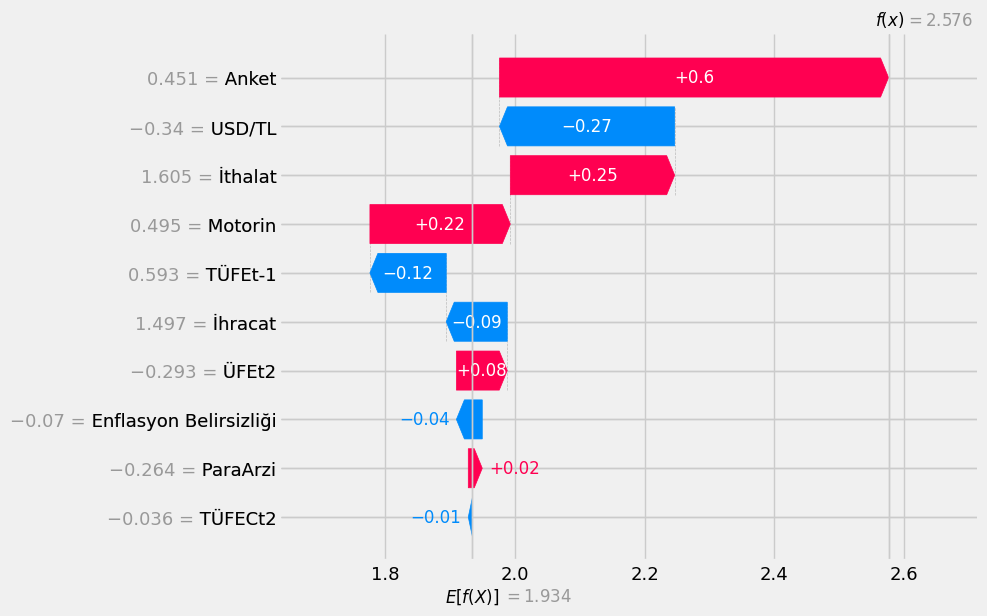

In [52]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


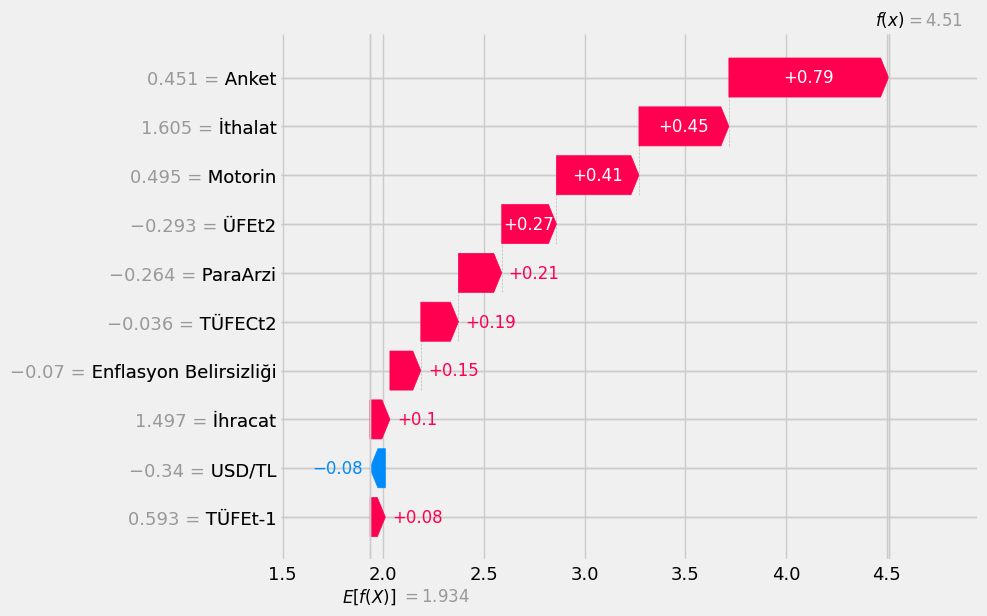

In [53]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.934 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    ),max_display=20
)


In [328]:
shap_values_rescaled = shap_values_reshaped * scaler2.scale_[0]

In [124]:
features=['Motorin','USD/TL', 'M3', 'Enflasyon Belirsizliği', 'Anket','Kredi', 'ÜFEt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=115,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.08154264548540417)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.023117556598032486)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=7,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler.columns=["TÜFE"]
tahminler["NN1"]=scaler2.inverse_transform(y_pred)
tahminler=tahminler.set_index(data.index[-7:])

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.7697 - mean_squared_error: 0.9731 - val_loss: 1.5199 - val_mean_squared_error: 1.0726
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6794 - mean_squared_error: 0.2907 - val_loss: 0.4544 - val_mean_squared_error: 0.2306
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4333 - mean_squared_error: 0.2407 - val_loss: 0.2940 - val_mean_squared_error: 0.1841
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3920 - mean_squared_error: 0.2962 - val_loss: 0.1758 - val_mean_squared_error: 0.0912
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3538 - mean_squared_error: 0.2791 - val_loss: 0.1828 - val_mean_squared_error: 0.1011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [125]:
mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["NN1"].iloc[:-1])

0.19277841214645486

In [126]:
tahminler

,TÜFE,NN1
2024-02-29,4.529188,4.444944
2024-03-31,3.162671,3.765424
2024-04-30,3.179759,3.165848
2024-05-31,3.368063,2.767795
2024-06-30,1.640774,2.198196
2024-07-31,3.225556,2.886400
2024-08-31,0.000000,2.518108


In [ ]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


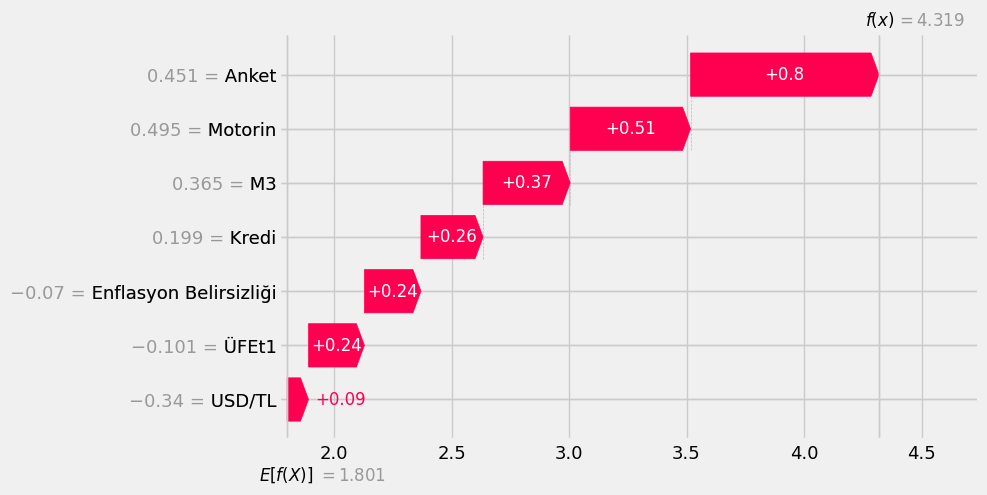

In [253]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.801 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [37]:
from sklearn.model_selection import train_test_split

In [258]:
study.best_params

{'learning_rate': 0.0032753771994387506,
 'units1': 167,
 'batch_size': 49,
 'activation1': 'selu',
 'optimizer': 'adam',
 'rlrate': 0.8578521656956516}

In [127]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi','İhracat','Anket',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=167,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.8578521656956516)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0032753771994387506)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=49,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler2=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler2.columns=["TÜFE"]
tahminler2["NN2"]=scaler2.inverse_transform(y_pred)
tahminler2=tahminler2.set_index(data.index[-7:])

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - loss: 21.0602 - mean_squared_error: 2.5092 - val_loss: 17.7703 - val_mean_squared_error: 0.8146
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 17.2271 - mean_squared_error: 0.5838 - val_loss: 15.2129 - val_mean_squared_error: 0.4092
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 14.9995 - mean_squared_error: 0.5063 - val_loss: 13.0372 - val_mean_squared_error: 0.3145
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.8518 - mean_squared_error: 0.4154 - val_loss: 11.1088 - val_mean_squared_error: 0.2888
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.8643 - mean_squared_error: 0.3018 - val_loss: 9.4710 - val_mean_squared_error: 0.3543
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 9.2112 - mean_squared_error: 0.3224 - val_loss: 8.0141 - val_mean_squared_error: 0.3986
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.7795 - mean_squared_error: 0.3627 - val_loss: 6

In [128]:
mean_squared_error(tahminler2["TÜFE"].iloc[:-1],tahminler2["NN2"].iloc[:-1])

0.09980239025321086

In [129]:
tahminler2

,TÜFE,NN2
2024-02-29,4.529188,4.862034
2024-03-31,3.162671,3.578190
2024-04-30,3.179759,3.089422
2024-05-31,3.368063,3.000761
2024-06-30,1.640774,1.886748
2024-07-31,3.225556,2.891197
2024-08-31,0.000000,2.312402


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 107 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 14%|█▍        | 1/7 [00:12<01:17, 12.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 6s 880us/step


 29%|██▊       | 2/7 [00:23<00:56, 11.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 6s 882us/step


 43%|████▎     | 3/7 [00:33<00:43, 10.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 57%|█████▋    | 4/7 [00:45<00:33, 11.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 71%|███████▏  | 5/7 [00:56<00:22, 11.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 962us/step


 86%|████████▌ | 6/7 [01:07<00:11, 11.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


100%|██████████| 7/7 [01:19<00:00, 11.31s/it]


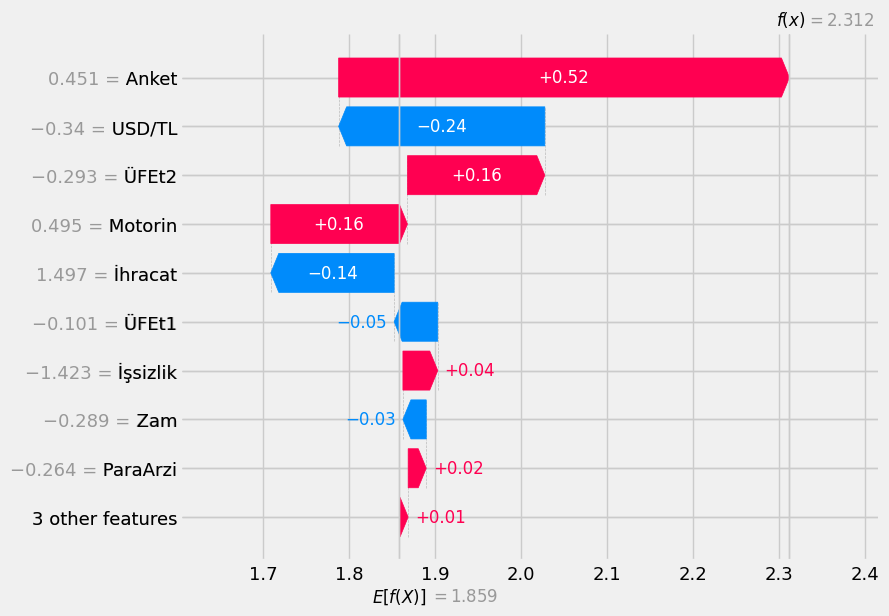

In [228]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


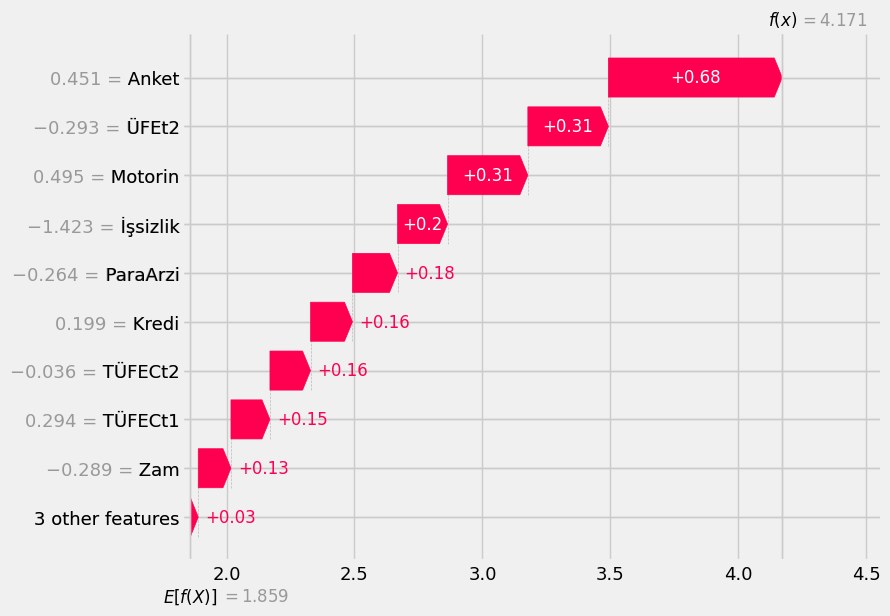

In [229]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.859 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [267]:
study.best_params

{'learning_rate': 0.006018245014889451,
 'units1': 67,
 'batch_size': 3,
 'activation1': 'tanh',
 'optimizer': 'adam',
 'rlrate': 0.0661993224622172}

In [130]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-13,:],X.iloc[-13:,:]
y_train,y_test=y[:-13],y[-13:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=67,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.0661993224622172)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.006018245014889451)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=3,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler3=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler3.columns=["TÜFE"]
tahminler3["NN3"]=scaler2.inverse_transform(y_pred)
tahminler3=tahminler3.set_index(data.index[-13:])


Epoch 1/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.7555 - mean_squared_error: 0.6255 - val_loss: 0.9273 - val_mean_squared_error: 0.2007
Epoch 2/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9194 - mean_squared_error: 0.2780 - val_loss: 0.5240 - val_mean_squared_error: 0.0839
Epoch 3/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5733 - mean_squared_error: 0.1781 - val_loss: 0.3544 - val_mean_squared_error: 0.0696
Epoch 4/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4100 - mean_squared_error: 0.1516 - val_loss: 0.2710 - val_mean_squared_error: 0.0740
Epoch 5/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3377 - mean_squared_error: 0.1560 - val_loss: 0.2322 - val_mean_squared_error: 0.0886
Epoch 6/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2817 - mean_squared_error: 0.1472 - val_loss: 0.1989 - val_mean_squared_error: 0.0854
Epoch 7/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2566 - mean_squared_error: 0.1493 - val_loss: 0.1

In [131]:
tahminler3

,TÜFE,NN3
2023-08-31,9.086793,9.235556
2023-09-30,4.753114,5.150928
2023-10-31,3.433981,2.897336
2023-11-30,3.281097,3.226030
2023-12-31,2.927207,3.057994
2024-01-31,6.703310,6.828334
2024-02-29,4.529188,4.474267
2024-03-31,3.162671,2.929663
2024-04-30,3.179759,2.736320
2024-05-31,3.368063,2.659871


In [132]:
mean_squared_error(tahminler3["TÜFE"].iloc[:-1],tahminler3["NN3"].iloc[:-1])

0.1116120907783205

In [277]:
study.best_params

{'learning_rate': 0.007869572470532615,
 'units1': 30,
 'batch_size': 32,
 'activation1': 'tanh',
 'optimizer': 'adam',
 'rlrate': 0.0648134949904951}

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 101 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/13 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  8%|▊         | 1/13 [00:12<02:31, 12.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 15%|█▌        | 2/13 [00:23<02:06, 11.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 23%|██▎       | 3/13 [00:35<01:59, 11.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 31%|███       | 4/13 [00:48<01:50, 12.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 38%|███▊      | 5/13 [01:01<01:39, 12.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 46%|████▌     | 6/13 [01:14<01:29, 12.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 54%|█████▍    | 7/13 [01:27<01:16, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 62%|██████▏   | 8/13 [01:40<01:04, 12.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 69%|██████▉   | 9/13 [01:51<00:49, 12.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 6s 863us/step


 77%|███████▋  | 10/13 [02:01<00:34, 11.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 85%|████████▍ | 11/13 [02:12<00:22, 11.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 6s 949us/step


 92%|█████████▏| 12/13 [02:22<00:10, 10.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 6s 911us/step


100%|██████████| 13/13 [02:32<00:00, 11.71s/it]


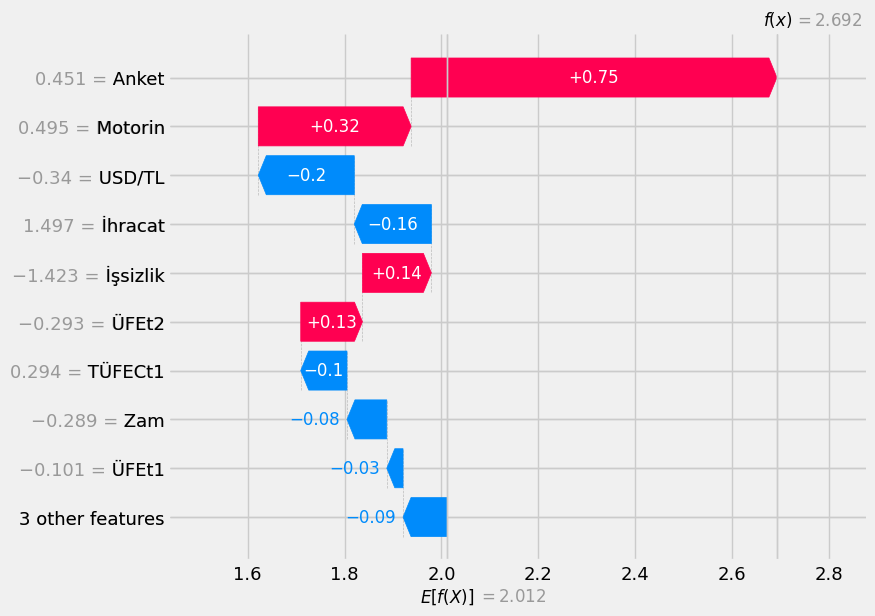

In [232]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


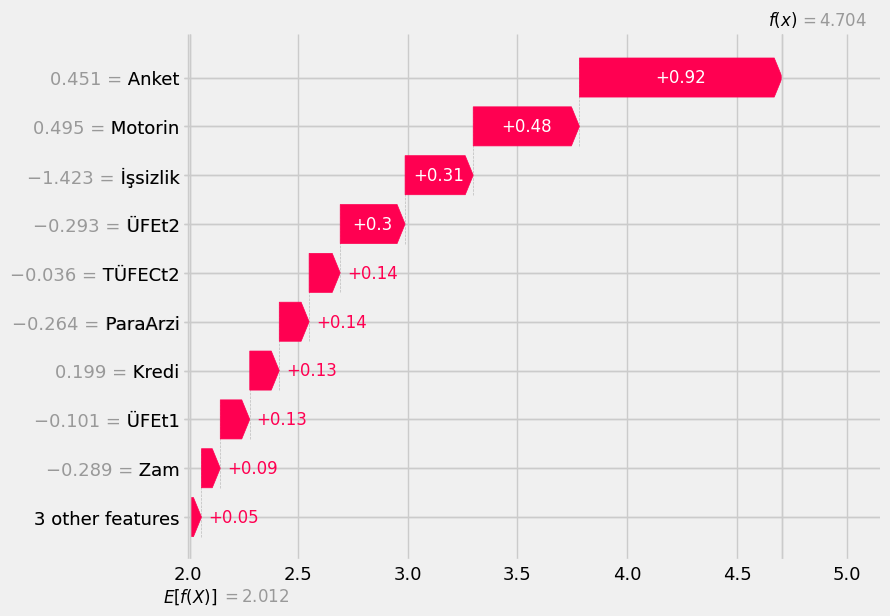

In [233]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (2.012 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [133]:
features=['USD/TL','Motorin','Anket','Enflasyon Belirsizliği','ÜFEt1','ParaArzi','TÜFEt-1','TÜFECt1','Zam','Kredi','ÜFEt2','TÜFECt2' ,'TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=30,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.0648134949904951)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.007869572470532615)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=32,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler4=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler4.columns=["TÜFE"]
tahminler4["NN4"]=scaler2.inverse_transform(y_pred)
tahminler4=tahminler4.set_index(data.index[-7:])

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 3.0433 - mean_squared_error: 1.9657 - val_loss: 1.7526 - val_mean_squared_error: 0.7279
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6399 - mean_squared_error: 0.6296 - val_loss: 1.4092 - val_mean_squared_error: 0.4639
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6033 - mean_squared_error: 0.6754 - val_loss: 1.1860 - val_mean_squared_error: 0.3306
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3382 - mean_squared_error: 0.4998 - val_loss: 1.0075 - val_mean_squared_error: 0.2371
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0798 - mean_squared_error: 0.3249 - val_loss: 0.9902 - val_mean_squared_error: 0.2970
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0008 - mean_squared_error: 0.3217 - val_loss: 0.9101 - val_mean_squared_error: 0.2872
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8959 - mean_squared_error: 0.2857 - val_loss: 0.7505 - v

In [533]:
tahminler4

,TÜFE,NN4
2024-02-29,4.529188,4.691705
2024-03-31,3.162671,3.537683
2024-04-30,3.179759,3.287085
2024-05-31,3.368063,2.960454
2024-06-30,1.640774,1.800534
2024-07-31,3.225556,3.037022
2024-08-31,0.000000,2.378066


In [532]:
mean_squared_error(tahminler4["TÜFE"].iloc[:-1],tahminler4["NN4"].iloc[:-1])

0.06762976840580044

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 107 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 14%|█▍        | 1/7 [00:12<01:14, 12.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 29%|██▊       | 2/7 [00:26<01:06, 13.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 43%|████▎     | 3/7 [00:39<00:52, 13.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 999us/step


 57%|█████▋    | 4/7 [00:50<00:37, 12.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 71%|███████▏  | 5/7 [01:03<00:25, 12.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 86%|████████▌ | 6/7 [01:16<00:12, 12.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


100%|██████████| 7/7 [01:28<00:00, 12.58s/it]


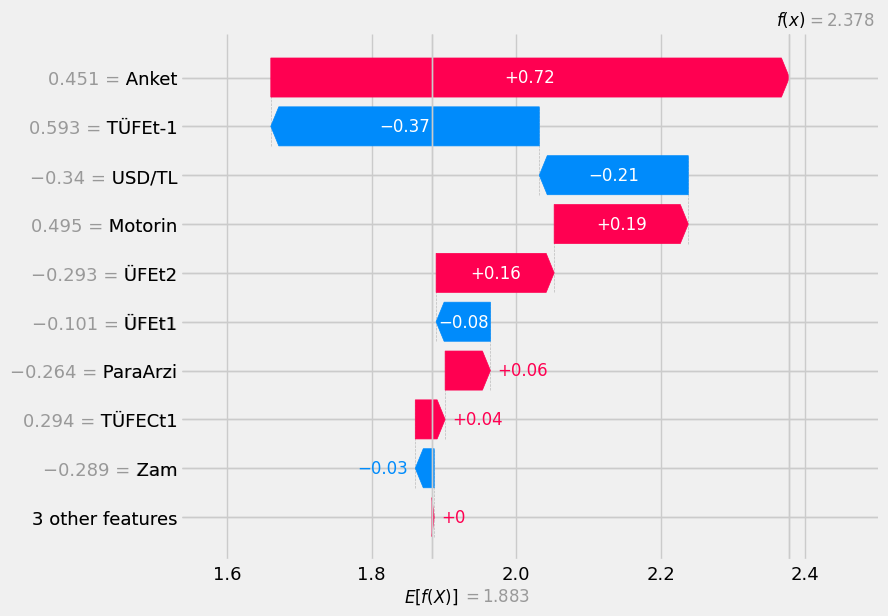

In [236]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


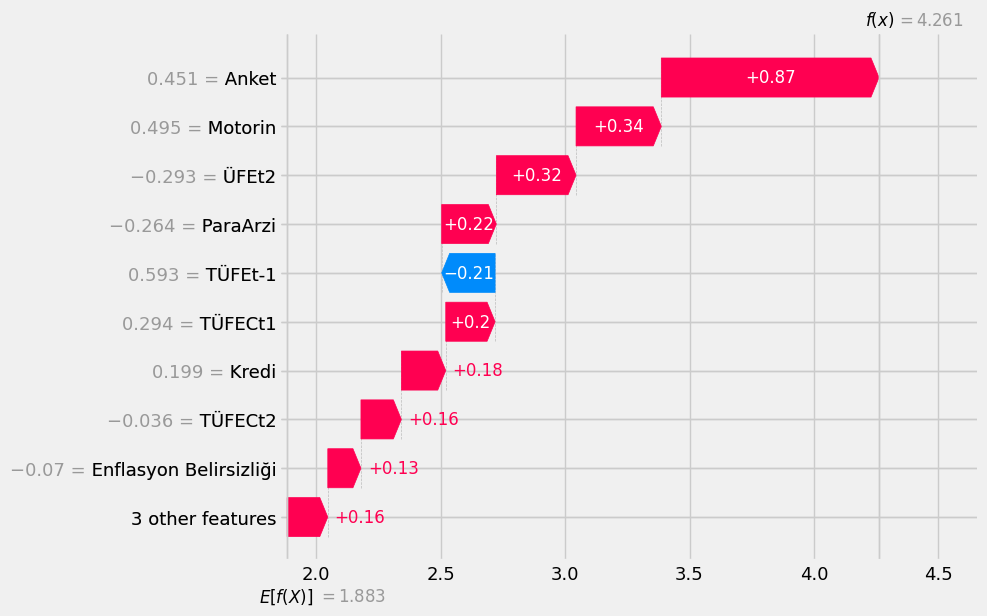

In [238]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.883 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [134]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-14,:],X.iloc[-14:,:]
y_train,y_test=y[:-14],y[-14:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=5,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.8310286967708689)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.010246301807480833)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=5000, batch_size=15,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler5=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler5.columns=["TÜFE"]
tahminler5["NN5"]=scaler2.inverse_transform(y_pred)
tahminler5=tahminler5.set_index(data.index[-14:])

Epoch 1/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 8.6573 - mean_squared_error: 2.8596 - val_loss: 5.5240 - val_mean_squared_error: 0.7832
Epoch 2/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3918 - mean_squared_error: 1.9560 - val_loss: 3.7312 - val_mean_squared_error: 0.2460
Epoch 3/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6811 - mean_squared_error: 1.4447 - val_loss: 2.5653 - val_mean_squared_error: 0.0931
Epoch 4/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3510 - mean_squared_error: 1.0751 - val_loss: 1.7406 - val_mean_squared_error: 0.0578
Epoch 5/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4182 - mean_squared_error: 0.8831 - val_loss: 1.1447 - val_mean_squared_error: 0.0470
Epoch 6/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7469 - mean_squared_error: 0.7514 - val_loss: 0.7479 - val_mean_squared_error: 0.0503
Epoch 7/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2786 - mean_squared_error: 0.6466 - val_loss: 0.4932 - val_mean

In [288]:
mean_squared_error(tahminler5["TÜFE"].iloc[:-1],tahminler5["NN5"].iloc[:-1])

0.16714036176338307

In [289]:
tahminler5

,TÜFE,NN5
2023-07-31,9.488824,9.282570
2023-08-31,9.086793,9.082348
2023-09-30,4.753114,5.444154
2023-10-31,3.433981,3.228026
2023-11-30,3.281097,3.184567
2023-12-31,2.927207,2.970706
2024-01-31,6.703310,6.414649
2024-02-29,4.529188,4.334896
2024-03-31,3.162671,3.251153
2024-04-30,3.179759,2.867944


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  7%|▋         | 1/14 [00:13<02:57, 13.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 14%|█▍        | 2/14 [00:26<02:41, 13.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 21%|██▏       | 3/14 [00:39<02:21, 12.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 29%|██▊       | 4/14 [00:51<02:05, 12.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 6s 999us/step


 36%|███▌      | 5/14 [01:02<01:48, 12.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 43%|████▎     | 6/14 [01:14<01:36, 12.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 50%|█████     | 7/14 [01:26<01:25, 12.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 6s 949us/step


 57%|█████▋    | 8/14 [01:37<01:09, 11.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 6s 923us/step


 64%|██████▍   | 9/14 [01:46<00:54, 10.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 71%|███████▏  | 10/14 [01:58<00:44, 11.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 79%|███████▊  | 11/14 [02:09<00:33, 11.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 86%|████████▌ | 12/14 [02:20<00:22, 11.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 6s 898us/step


 93%|█████████▎| 13/14 [02:30<00:10, 10.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 6s 891us/step


100%|██████████| 14/14 [02:39<00:00, 11.41s/it]


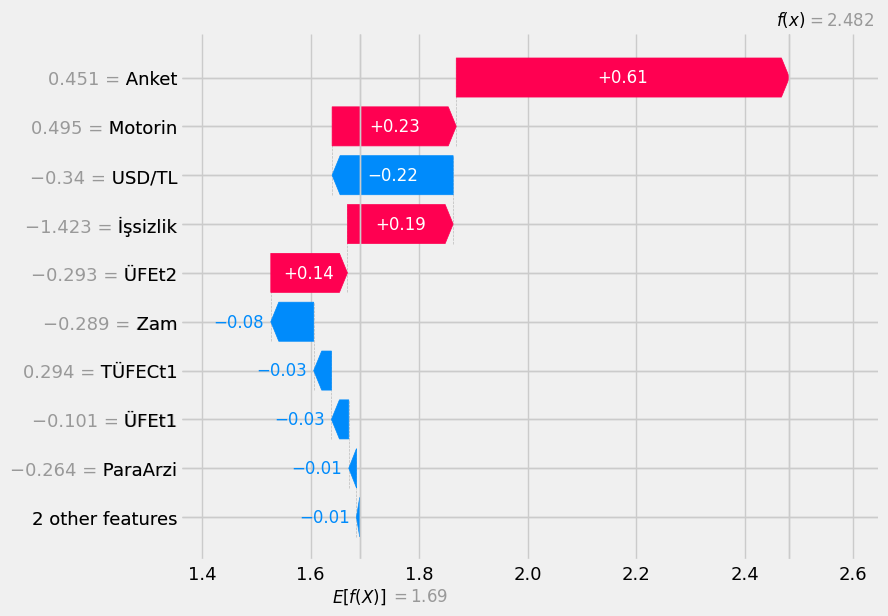

In [240]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


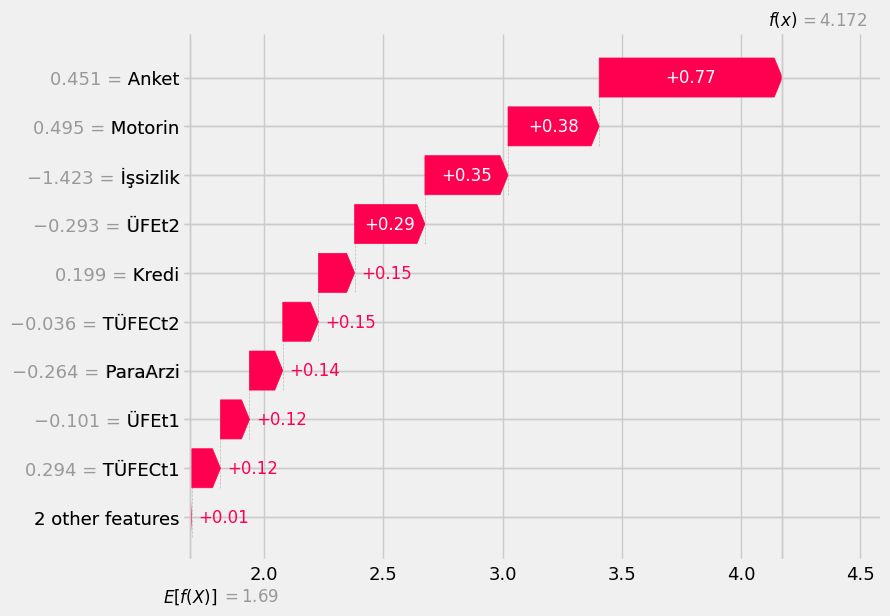

In [241]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.69 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [294]:
study.best_params

{'learning_rate': 0.0004324233099094171,
 'units1': 143,
 'batch_size': 30,
 'activation1': 'linear',
 'optimizer': 'adam',
 'rlrate': 0.1679762527788078}

In [135]:
features=['Anket','Enflasyon Belirsizliği','ÜFEt1','ParaArzi','USD/TL','Motorin','TÜFEt-1','TÜFECt1','Kredi','ÜFEt2','Zam','TÜFECt2','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=143,activation="linear",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.1679762527788078)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004324233099094171)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=30,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler6=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler6.columns=["TÜFE"]
tahminler6["NN6"]=scaler2.inverse_transform(y_pred)
tahminler6=tahminler6.set_index(data.index[-7:])

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 4.1590 - mean_squared_error: 0.5779 - val_loss: 4.2842 - val_mean_squared_error: 0.7260
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.9025 - mean_squared_error: 0.3519 - val_loss: 4.0270 - val_mean_squared_error: 0.5084
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.7781 - mean_squared_error: 0.2695 - val_loss: 3.8455 - val_mean_squared_error: 0.3772
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.7119 - mean_squared_error: 0.2553 - val_loss: 3.7129 - val_mean_squared_error: 0.3023
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.6486 - mean_squared_error: 0.2505 - val_loss: 3.6096 - val_mean_squared_error: 0.2598
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.5730 - mean_squared_error: 0.2360 - val_loss: 3.5249 - val_mean_squared_error: 0.2370
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.4928 - mean_squared_error: 0.2178 - val_loss: 3.4514 - v

In [244]:
tahminler6

,TÜFE,NN6
2024-02-29,4.529188,4.504927
2024-03-31,3.162671,3.600996
2024-04-30,3.179759,3.183633
2024-05-31,3.368063,2.815168
2024-06-30,1.640774,1.663040
2024-07-31,3.225556,3.041881
2024-08-31,0.000000,2.423042


In [298]:
mean_squared_error(tahminler6["TÜFE"].iloc[:-1],tahminler6["NN6"].iloc[:-1])

0.08877587233828987

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 107 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 14%|█▍        | 1/7 [00:12<01:14, 12.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 6s 929us/step


 29%|██▊       | 2/7 [00:23<00:58, 11.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 43%|████▎     | 3/7 [00:37<00:50, 12.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 57%|█████▋    | 4/7 [00:49<00:37, 12.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 71%|███████▏  | 5/7 [01:01<00:24, 12.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 6s 914us/step


 86%|████████▌ | 6/7 [01:12<00:11, 11.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


100%|██████████| 7/7 [01:24<00:00, 12.08s/it]


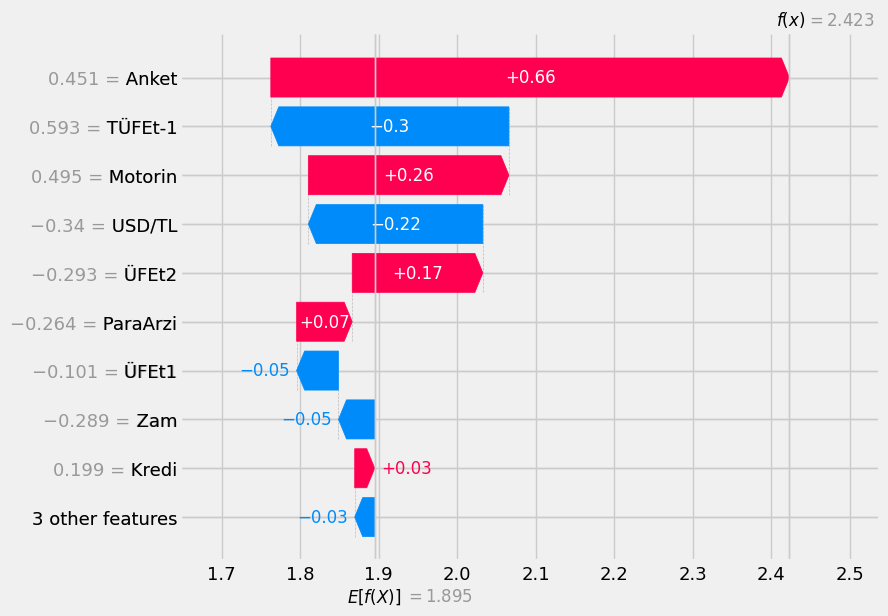

In [243]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)

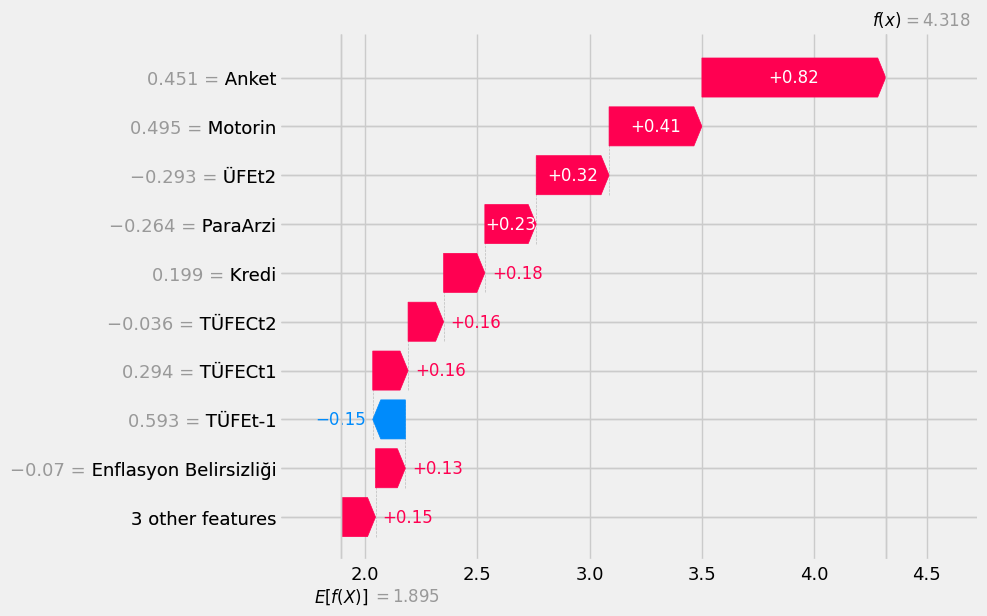

In [245]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.895 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [136]:
features=['Anket','Enflasyon Belirsizliği','ÜFEt1','ParaArzi','USD/TL','Motorin','TÜFEt-1','TÜFECt1','Kredi','ÜFEt2','Zam','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=25,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.9508439168991856)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.004681420261569405)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=5000, batch_size=20,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler7=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler7.columns=["TÜFE"]
tahminler7["NN7"]=scaler2.inverse_transform(y_pred)
tahminler7=tahminler7.set_index(data.index[-7:])

Epoch 1/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 14.7775 - mean_squared_error: 0.8843 - val_loss: 13.0911 - val_mean_squared_error: 1.1614
Epoch 2/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.8710 - mean_squared_error: 0.4675 - val_loss: 10.4094 - val_mean_squared_error: 0.7507
Epoch 3/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.5572 - mean_squared_error: 0.3601 - val_loss: 8.2196 - val_mean_squared_error: 0.5392
Epoch 4/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6025 - mean_squared_error: 0.3137 - val_loss: 6.4573 - val_mean_squared_error: 0.4398
Epoch 5/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9816 - mean_squared_error: 0.2853 - val_loss: 5.0481 - val_mean_squared_error: 0.3838
Epoch 6/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6692 - mean_squared_error: 0.2619 - val_loss: 3.9035 - val_mean_squared_error: 0.3168
Epoch 7/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6192 - mean_squared_error: 0.2354 - val_loss: 2.9903 - 

In [247]:
tahminler7

,TÜFE,NN7
2024-02-29,4.529188,4.329136
2024-03-31,3.162671,3.514034
2024-04-30,3.179759,3.093330
2024-05-31,3.368063,2.702667
2024-06-30,1.640774,1.631842
2024-07-31,3.225556,2.948690
2024-08-31,0.000000,2.312694


In [308]:
mean_squared_error(tahminler7["TÜFE"].iloc[:-1],tahminler7["NN7"].iloc[:-1])

0.11507159585202247

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 107 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 14%|█▍        | 1/7 [00:13<01:22, 13.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 29%|██▊       | 2/7 [00:25<01:04, 12.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 43%|████▎     | 3/7 [00:38<00:51, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 57%|█████▋    | 4/7 [00:52<00:39, 13.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 7s 984us/step


 71%|███████▏  | 5/7 [01:04<00:25, 12.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 86%|████████▌ | 6/7 [01:16<00:12, 12.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


100%|██████████| 7/7 [01:27<00:00, 12.57s/it]


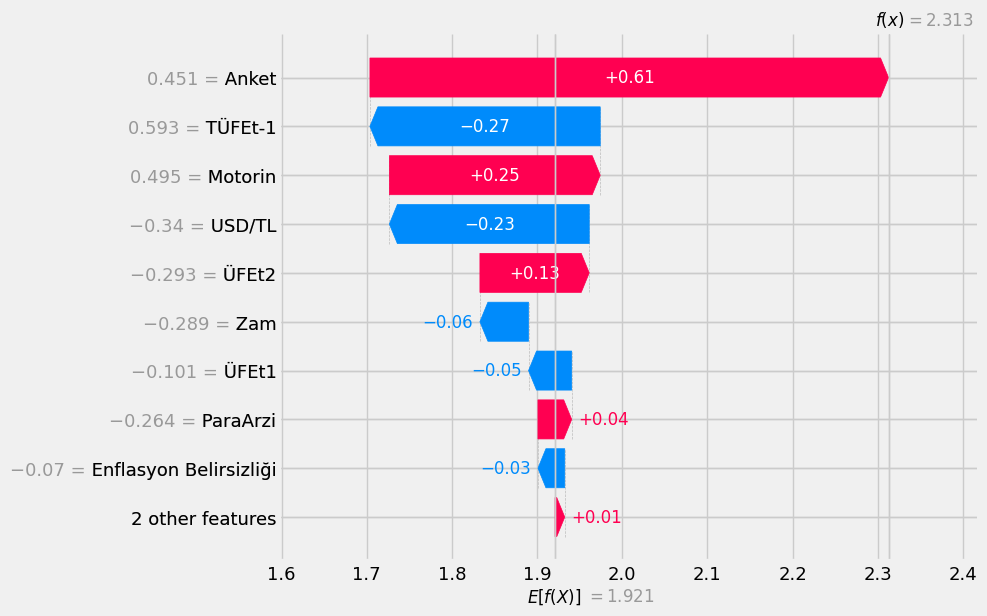

In [248]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)

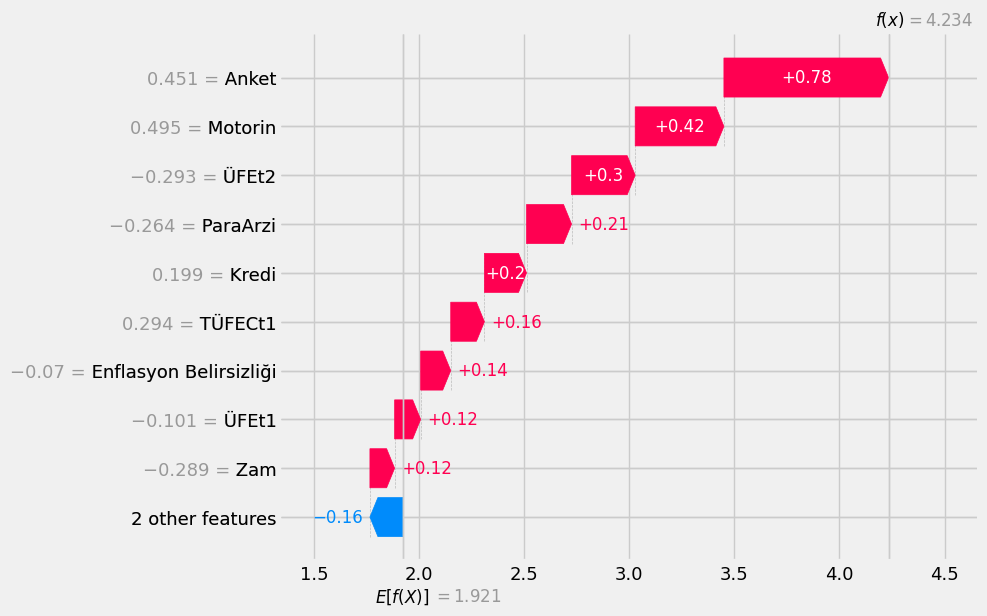

In [249]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.921 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [137]:
kısatahminler=pd.concat([data["TÜFE"].iloc[-14:],tahminler.iloc[:,1],tahminler2.iloc[:,1],tahminler3.iloc[:,1],tahminler4.iloc[:,1],tahminler5.iloc[:,1],tahminler6.iloc[:,1],tahminler7.iloc[:,1]],axis=1)
kısatahminler["Ortalama"]=kısatahminler.iloc[:,1:].mean(axis=1)
kısatahminler.loc["2024-05-31", ["NN1","NN2","NN3","NN4","NN5","NN6","NN7","Ortalama"]] += 0.66
kısatahminler

,TÜFE,NN1,NN2,NN3,NN4,NN5,NN6,NN7,Ortalama
2023-07-31,9.488824,NaN,NaN,NaN,NaN,9.282584,NaN,NaN,9.282584
2023-08-31,9.086793,NaN,NaN,9.235556,NaN,9.082389,NaN,NaN,9.158972
2023-09-30,4.753114,NaN,NaN,5.150928,NaN,5.444156,NaN,NaN,5.297542
2023-10-31,3.433981,NaN,NaN,2.897336,NaN,3.228025,NaN,NaN,3.062680
2023-11-30,3.281097,NaN,NaN,3.226030,NaN,3.184568,NaN,NaN,3.205299
2023-12-31,2.927207,NaN,NaN,3.057994,NaN,2.970708,NaN,NaN,3.014351
2024-01-31,6.703310,NaN,NaN,6.828334,NaN,6.414598,NaN,NaN,6.621466
2024-02-29,4.529188,4.444944,4.862034,4.474267,4.691705,4.334888,4.504927,4.329136,4.520272
2024-03-31,3.162671,3.765424,3.578190,2.929663,3.537683,3.251155,3.600996,3.514034,3.453878
2024-04-30,3.179759,3.165848,3.089422,2.736320,3.287085,2.867946,3.183633,3.093330,3.060512


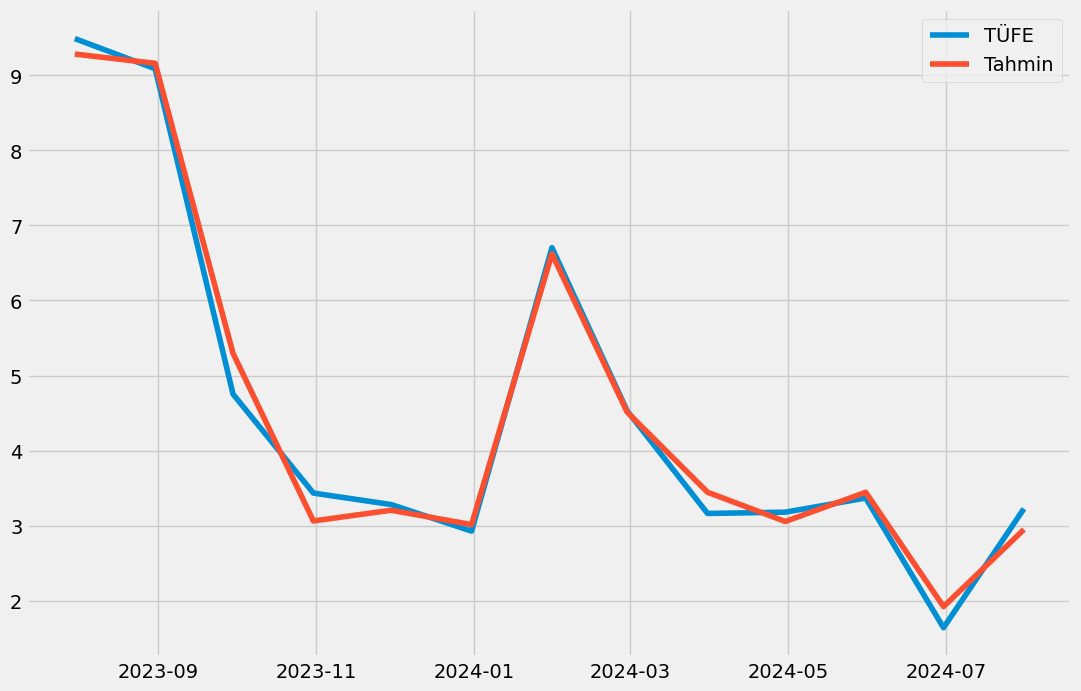

In [333]:
plt.figure(figsize=(12,8))
plt.plot(kısatahminler["TÜFE"].iloc[:-1],label="TÜFE")
plt.plot(kısatahminler["Ortalama"].iloc[:-1],label="Tahmin")
plt.legend()

## Orta Vadeli Tahminler

In [41]:
model=auto_arima(pfaiz["Faiz"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Faiz"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Faiz"]
row=pd.DataFrame({"Faiz":pfaiz.iloc[-4:,0]},index=pd.date_range(start="2024-05-30",periods=4,freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)

faiztahmin.iloc[4:,0]=[50,50,50,50,50,50,50,50,50,50,50,45,40,35,35,35,35,30,30,30,30,30,25,25,25]
faiztahmin

,Faiz
2024-05-31,50.544545
2024-06-30,50.106471
2024-07-31,50.000000
2024-08-31,50.614286
2024-09-30,50.000000
2024-10-31,50.000000
2024-11-30,50.000000
2024-12-31,50.000000
2025-01-31,50.000000
2025-02-28,50.000000


In [42]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [43]:
exog=pd.DataFrame()
exog["X"]=usd["USD/TL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.897922
2007-08-31,94.606608
2007-10-31,98.111410
2007-11-30,110.422510
2007-12-31,107.237150
...,...
2024-01-31,2403.605577
2024-02-29,2542.824291
2024-04-30,2888.414877
2024-05-31,2678.660533


In [44]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,25]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [45]:
faiztahmin.columns=["Faiz"]


In [46]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Faiz"].iloc[95:-13]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Faiz"].iloc[-14:-3],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [47]:
exog=pfaiz["Faiz"].iloc[36:-3]
exog=np.array(exog).reshape(-1,1)

In [48]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [49]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(27,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2024-06-30,8.391686
2024-07-31,8.373415
2024-08-31,8.356908
2024-09-30,8.353280
2024-10-31,8.351119
2024-11-30,8.345414
2024-12-31,8.344594
2025-01-31,8.344105
2025-02-28,8.342815
2025-03-31,8.342629


In [50]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [57]:
import optuna


In [34]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.50,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=usd.index
    sn["y"]=usd.values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=500,freq="D")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(usd.values,predictions["yhat"][:-500])
    return mae_score
try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)
    print("Optimize işlemi başarıyla tamamlandı.")
except Exception as e:
    print(f'Hata oluştu: {e}')
    print('Optimize işlemi başarısız oldu. Devam ediyor...')
"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.01, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.50,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=usd.index\n    sn["y"]=usd.values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],sea

In [35]:
"""study.best_params"""

'study.best_params'

In [58]:
sn=pd.DataFrame()
sn["ds"]=usd.index
sn["y"]=usd.values
prophet=Prophet(growth="linear",changepoint_prior_scale=8.828175414699565,changepoint_range=0.950080828826867,seasonality_prior_scale=7.816953755754968,n_changepoints=100,interval_width=0.70,yearly_seasonality=False,weekly_seasonality="auto")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=500,freq="D")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

12:21:13 - cmdstanpy - INFO - Chain [1] start processing
12:21:23 - cmdstanpy - INFO - Chain [1] done processing


In [151]:
(predictions["yhat"].resample('M').mean().tail(18).pct_change()*100).dropna()

ds
2024-08-31    1.766774
2024-09-30    1.589661
2024-10-31    1.605180
2024-11-30    1.584042
2024-12-31    1.556557
2025-01-31    1.556662
2025-02-28    1.461721
2025-03-31    1.440944
2025-04-30    1.464371
2025-05-31    1.446765
2025-06-30    1.425362
2025-07-31    1.403306
2025-08-31    1.411376
2025-09-30    1.363648
2025-10-31    1.347523
2025-11-30    1.333501
2025-12-31    1.115906
Freq: ME, Name: yhat, dtype: float64

In [59]:
usdtahmin=(predictions["yhat"].resample('M').mean().tail(18).pct_change()*100).dropna()
usdtahmin

ds
2024-08-31    1.766774
2024-09-30    1.589661
2024-10-31    1.605180
2024-11-30    1.584042
2024-12-31    1.556557
2025-01-31    1.556662
2025-02-28    1.461721
2025-03-31    1.440944
2025-04-30    1.464371
2025-05-31    1.446765
2025-06-30    1.425362
2025-07-31    1.403306
2025-08-31    1.411376
2025-09-30    1.363648
2025-10-31    1.347523
2025-11-30    1.333501
2025-12-31    1.115906
Freq: ME, Name: yhat, dtype: float64

In [60]:
usd_aylık=usd.resample('M').mean().dropna()

In [61]:
usdtahmin1 = []
result = usd_aylık.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([usd_aylık["USD/TL"].loc["2024-03-31":],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2024-03-31", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2024-03-31,31.986743
2024-04-30,32.329467
2024-05-31,32.247882
2024-06-30,32.521235
2024-07-31,32.894495
2024-08-31,33.322386
2024-09-30,33.911117
2024-10-31,34.450189
2024-11-30,35.003176
2024-12-31,35.557641


In [41]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'growth':trial.suggest_categorical('growth',['linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[50:].index
    sn["y"]=df14[50:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[50:].index\n    sn["y"]=df14[50:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = optuna.create_study(direction=

In [42]:
"""study.best_params"""

'study.best_params'

In [66]:
sn=pd.DataFrame()
sn["ds"]=df14.index
sn["y"]=df14.values
prophet=Prophet(growth="linear",changepoint_prior_scale=9.333547662504625,changepoint_range=0.9362159367416,seasonality_prior_scale=2.378940289163559,n_changepoints=98)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

12:21:41 - cmdstanpy - INFO - Chain [1] start processing
12:21:42 - cmdstanpy - INFO - Chain [1] done processing


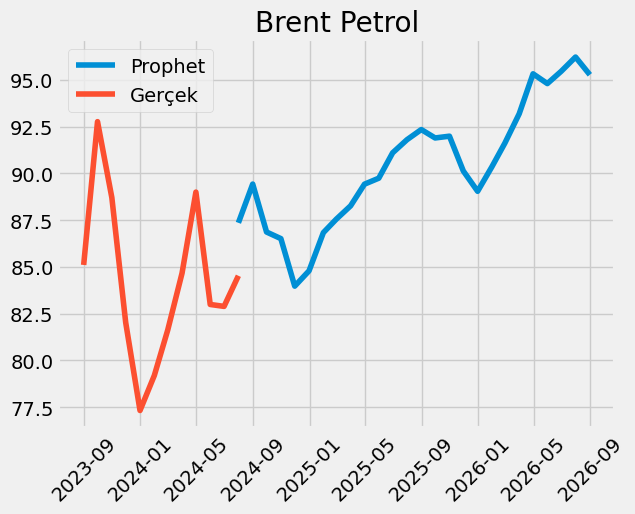

In [40]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-26:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [67]:
brenttahmin=predictions["yhat"][-29:]
brenttahmin

ds
2024-05-31    83.307534
2024-06-30    84.296904
2024-07-31    83.909642
2024-08-31    84.558825
2024-09-30    82.812987
2024-10-31    82.566522
2024-11-30    80.264771
2024-12-31    79.760946
2025-01-31    83.682885
2025-02-28    83.129733
2025-03-31    83.956265
2025-04-30    83.470699
2025-05-31    83.793456
2025-06-30    84.227143
2025-07-31    83.998682
2025-08-31    83.616739
2025-09-30    83.490163
2025-10-31    83.745190
2025-11-30    81.872769
2025-12-31    80.147847
2026-01-31    82.429728
2026-02-28    83.257421
2026-03-31    84.478183
2026-04-30    85.476570
2026-05-31    84.245265
2026-06-30    84.137133
2026-07-31    84.074734
2026-08-31    82.690064
2026-09-30    84.206730
Name: yhat, dtype: float64

In [46]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'growth':trial.suggest_categorical('growth',['linear'])

            

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n\n            \n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = o

13:18:52 - cmdstanpy - INFO - Chain [1] start processing
13:18:52 - cmdstanpy - INFO - Chain [1] done processing


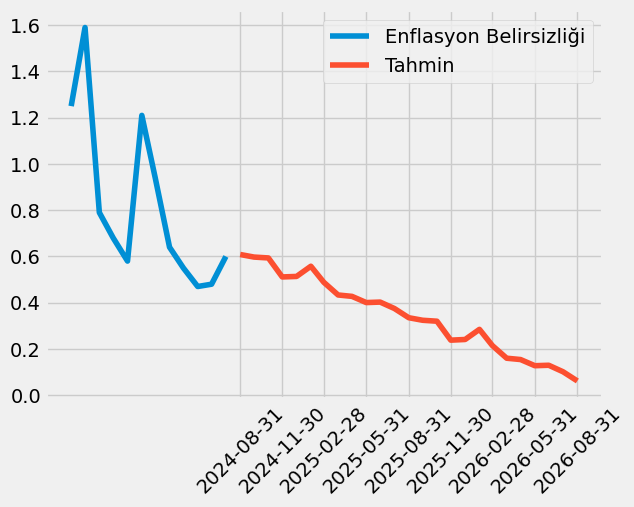

In [91]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
prophet=Prophet(changepoint_prior_scale=5,changepoint_range=0.85,seasonality_prior_scale=0.0053403857042852,n_changepoints=4,growth="linear")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])
plt.plot(enf_belirsizlik[-12:],label="Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.xticks(predictions.index[-25::3],rotation=45)
plt.legend()

In [92]:
enfbelirsizliktahmin1=pd.DataFrame(predictions["yhat"][-26:])
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1.index.names=[""]
enfbelirsizliktahmin1.iloc[0,0]=enf_belirsizlik.iloc[-1,0]
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
,
2024-07-31,0.600000
2024-08-31,0.608391
2024-09-30,0.597280
2024-10-31,0.593522
2024-11-30,0.511384
2024-12-31,0.513562
2025-01-31,0.557677
2025-02-28,0.488279
2025-03-31,0.433377


In [49]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [50]:
#study.best_params

In [70]:
brenttahmin1=(brenttahmin.pct_change()*100).dropna()
brenttahmin1

ds
2024-06-30    1.187612
2024-07-31   -0.459402
2024-08-31    0.773668
2024-09-30   -2.064643
2024-10-31   -0.297617
2024-11-30   -2.787754
2024-12-31   -0.627703
2025-01-31    4.917116
2025-02-28   -0.661009
2025-03-31    0.994268
2025-04-30   -0.578356
2025-05-31    0.386670
2025-06-30    0.517567
2025-07-31   -0.271244
2025-08-31   -0.454701
2025-09-30   -0.151376
2025-10-31    0.305458
2025-11-30   -2.235855
2025-12-31   -2.106833
2026-01-31    2.847090
2026-02-28    1.004119
2026-03-31    1.466250
2026-04-30    1.181828
2026-05-31   -1.440518
2026-06-30   -0.128354
2026-07-31   -0.074163
2026-08-31   -1.646952
2026-09-30    1.834158
Name: yhat, dtype: float64

In [59]:
(usdtahmin1[:-5].pct_change(periods=1)*100).dropna()

,USD/TL
2024-04-30,1.071456
2024-05-31,-0.252354
2024-06-30,0.847663
2024-07-31,1.119131
2024-08-31,1.790069
2024-09-30,1.682186
2024-10-31,1.649177
2024-11-30,1.631295
2024-12-31,1.599443
2025-01-31,1.597841


In [53]:
(brenttahmin1[:-7]).dropna()

ds
2024-05-31    1.003012
2024-06-30    2.348736
2024-07-31    1.178192
2024-08-31    2.824667
2024-09-30   -2.624859
2024-10-31    0.313325
2024-11-30   -2.491957
2024-12-31    0.860392
2025-01-31    1.536794
2025-02-28    0.774586
2025-03-31    0.971680
2025-04-30    1.369275
2025-05-31    0.258661
2025-06-30    1.592406
2025-07-31    1.204928
2025-08-31    1.090437
2025-09-30   -0.221929
2025-10-31    0.492880
2025-11-30   -1.804315
2025-12-31   -1.264276
2026-01-31    1.095298
Name: yhat, dtype: float64

In [71]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1[:-6]).dropna())/100)).values.reshape(-1,1))
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2024-04-28",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2024-04-30,0.290660
2024-05-31,-0.710597
2024-06-30,1.627890
2024-07-31,-0.940597
2024-08-31,0.999308
2024-09-30,-1.070233
2024-10-31,0.951979
2024-11-30,6.601225
2024-12-31,0.912562
2025-01-31,2.566302


In [55]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_rang

In [72]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
prophet=Prophet(changepoint_prior_scale=0.904897796889,changepoint_range=0.9529543315216538,growth='linear',seasonality_prior_scale=3.03031163229546,n_changepoints=15)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

12:21:53 - cmdstanpy - INFO - Chain [1] start processing
12:21:53 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
paraarzitahmin=(predictions["yhat"]).tail(26)
paraarzitahmin

ds
2024-08-31    1.457644
2024-09-30    3.085309
2024-10-31    2.919855
2024-11-30    2.556161
2024-12-31    2.559556
2025-01-31    1.056315
2025-02-28    1.411848
2025-03-31    3.081978
2025-04-30    2.591877
2025-05-31    2.164970
2025-06-30    2.550946
2025-07-31    1.696647
2025-08-31    1.566943
2025-09-30    1.850961
2025-10-31    1.549193
2025-11-30    1.487006
2025-12-31    2.148558
2026-01-31    0.241659
2026-02-28    0.824692
2026-03-31    2.201415
2026-04-30    1.140571
2026-05-31    1.337914
2026-06-30    1.943596
2026-07-31    0.620678
2026-08-31    1.670947
2026-09-30    0.595415
Name: yhat, dtype: float64

In [74]:
paraarzitahmin1 = paraarzitahmin
paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-09-30", periods=len(paraarzitahmin), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-6:,0]},index=pd.date_range(start="2024-03-31",periods=6,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
np.cumprod(1+(paraarzitahmin1.loc["2024-01-31":"2024-12-31"])/100)

,Para Arzi
2024-03-31,1.023967
2024-04-30,1.044264
2024-05-31,1.063682
2024-06-30,1.096729
2024-07-31,1.123738
2024-08-31,1.122393
2024-09-30,1.138753
2024-10-31,1.173887
2024-11-30,1.208163
2024-12-31,1.239046


In [59]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [60]:
#study.best_params

In [61]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,5),
                'n_changepoints':trial.suggest_int('n_changepoints',1,200),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),


                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3.values,predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,5),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,200),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=

In [62]:
"""study.best_params"""

'study.best_params'

In [75]:
sn=pd.DataFrame()
sn["ds"]=kredi["Kredi"].index
sn["y"]=kredi["Kredi"].values
prophet=Prophet(changepoint_prior_scale=0.01099759561372614,changepoint_range=0.0589785485153,growth="linear",seasonality_prior_scale=0.04157847860739,n_changepoints=10,yearly_seasonality=True,weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

12:21:57 - cmdstanpy - INFO - Chain [1] start processing
12:21:57 - cmdstanpy - INFO - Chain [1] done processing


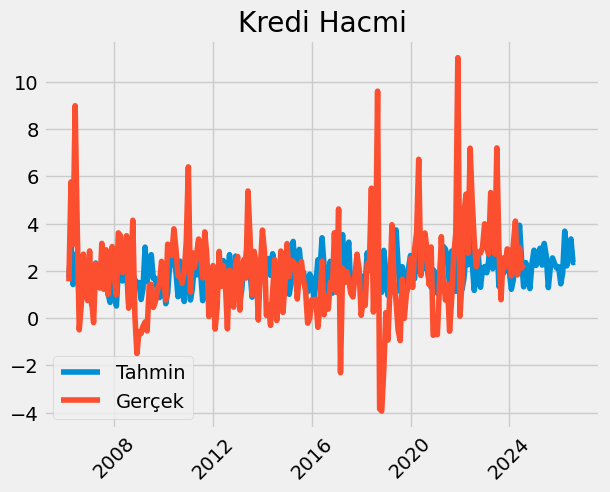

In [64]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(kredi["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [76]:
kreditahmin=(predictions["yhat"]).tail(26)
kreditahmin

ds
2024-08-31    2.237166
2024-09-30    1.743089
2024-10-31    1.161318
2024-11-30    2.194981
2024-12-31    2.776394
2025-01-31    2.132290
2025-02-28    2.576553
2025-03-31    2.867952
2025-04-30    2.113191
2025-05-31    3.057034
2025-06-30    2.547951
2025-07-31    1.140368
2025-08-31    2.085848
2025-09-30    2.447528
2025-10-31    2.208440
2025-11-30    2.037587
2025-12-31    2.052292
2026-01-31    1.342105
2026-02-28    1.800236
2026-03-31    3.574731
2026-04-30    2.099125
2026-05-31    2.897889
2026-06-30    3.245233
2026-07-31    2.183665
2026-08-31    2.246856
2026-09-30    1.731662
Name: yhat, dtype: float64

In [77]:
kreditahmin1 = kreditahmin

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-09-30", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":kredi.iloc[-4:,0]},index=pd.date_range(start="2024-05-30",periods=4,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2024-05-31,2.996833
2024-06-30,2.281882
2024-07-31,1.391026
2024-08-31,2.139562
2024-09-30,2.237166
2024-10-31,1.743089
2024-11-30,1.161318
2024-12-31,2.194981
2025-01-31,2.776394
2025-02-28,2.132290


In [67]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,150),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3"].index
    sn["y"]=m3["M3"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,150),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3"].index\n    sn["y"]=m3["M3"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["

In [78]:
sn=pd.DataFrame()
sn["ds"]=m3["M3"].index
sn["y"]=m3["M3"].values
prophet=Prophet(changepoint_prior_scale=2.5,changepoint_range=0.9,growth='linear',seasonality_prior_scale=4.7636997959024185,n_changepoints=10)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=18,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

12:22:02 - cmdstanpy - INFO - Chain [1] start processing
12:22:02 - cmdstanpy - INFO - Chain [1] done processing


In [79]:
m3tahmin=(predictions["yhat"].tail(18))


m3tahmin1 = np.array(m3tahmin).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-09-30", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-4:,0]},index=pd.date_range(start="2024-05-30",periods=4,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2024-05-31,3.570039
2024-06-30,2.937087
2024-07-31,3.270042
2024-08-31,4.398522
2024-09-30,3.446552
2024-10-31,3.649195
2024-11-30,3.270216
2024-12-31,2.553009
2025-01-31,1.614968
2025-02-28,2.112892


In [70]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [71]:
#study.best_params

In [72]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_int('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"].index
    sn["y"]=redkt["REDKT"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"],predictions["yhat"][:-36])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_int(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"].index\n    sn["y"]=redkt["REDKT"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scal

In [94]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean()],axis=1)

tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf["M3"]=m3tahmin1["M3"].shift(1)
tahmindf["Para Arzi"]=paraarzitahmin1.rolling(3).mean()
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Kredi"]=kreditahmin1["Kredi"].shift(1).rolling(3).mean()
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["İşsizlik"]=issizliktahmin





tahmindf=tahmindf[['USD/TL', 'Motorin', 'Zam',
       'Enflasyon Belirsizliği', 'Para Arzi', 'M3', 'Kredi','İşsizlik']]

tahmindf.columns=["USD/TL","Motorin","Zam","Enflasyon Belirsizliği",'ParaArzi','M3', 'Kredi','İşsizlik']



tahmindf=tahmindf.loc["2024-08-31":]
tahmindf["Motorin"].iloc[-1]=data["Motorin"].iloc[-1]
tahmindf["ParaArzi"].iloc[-1]=data["ParaArzi"].iloc[-1]
tahmindf["M3"].iloc[-1]=data["M3"].iloc[-1]
tahmindf["Kredi"].iloc[-1]=data["Kredi"].iloc[-1]
tahmindf

,USD/TL,Motorin,Zam,Enflasyon Belirsizliği,ParaArzi,M3,Kredi,İşsizlik
2024-08-31,1.100209,0.999308,0.0,0.608391,1.816613,3.270042,2.223247,8.356908
2024-09-30,1.407644,-1.070233,0.0,0.597280,1.266875,4.398522,1.937490,8.353280
2024-10-31,1.553704,0.951979,0.0,0.593522,1.474404,3.446552,1.922584,8.351119
2024-11-30,1.652960,6.601225,0.0,0.511384,2.487603,3.649195,2.039939,8.345414
2024-12-31,1.592931,0.912562,0.0,0.513562,2.853775,3.270216,1.713857,8.344594
2025-01-31,1.581670,2.566302,30.0,0.557677,2.678524,2.553009,1.699796,8.344105
2025-02-28,1.565611,0.969303,0.0,0.488279,2.057344,1.614968,2.044231,8.342815
2025-03-31,1.524491,1.854043,0.0,0.433377,1.675906,2.112892,2.367888,8.342629
2025-04-30,1.485862,1.965968,0.0,0.427352,1.850047,3.555606,2.495079,8.342519
2025-05-31,1.455692,1.189156,0.0,0.400581,2.361901,3.123414,2.525598,8.342227


In [95]:
features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İhracat', 'İthalat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','Anket','ParaArzi', 'TÜFE']

data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,TÜFEt-1,Kredi,İhracat,İthalat,İşsizlik,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,Anket,ParaArzi,TÜFE
0,0.068856,-0.371491,-0.806206,-0.938074,-0.647882,0.192910,0.275938,-0.665694,-0.813859,0.359487,-0.702132,-0.288578,-0.526904,-0.680206,-0.686977,-0.347333
1,-1.072249,-0.993701,-0.613367,-0.759297,-0.338442,-0.530196,0.846160,1.077718,-0.703058,-0.292136,-0.518092,-0.506659,-0.293943,-0.598369,-1.073045,-0.249930
2,-1.226470,-0.858511,-0.930658,-0.682678,-0.241111,-1.238867,-0.694821,-0.026438,-0.703058,-0.510114,-0.285510,-0.725841,0.138773,-0.695086,-1.289023,-0.671642
3,-1.144447,-0.152520,-1.089206,-0.529440,-0.662510,-1.006852,0.033294,-0.062830,-0.703058,-0.729193,0.146501,-0.930106,-0.150501,-1.000116,-0.941471,-0.709132
4,-0.711109,-0.103147,0.152153,-0.631599,-0.699973,-0.569675,-0.570181,-0.054829,-0.592257,-0.933361,-0.142301,-0.735836,-0.712668,-1.119152,-0.629180,-0.645360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.064815,-0.398896,0.140752,0.057971,0.565396,0.737713,0.460612,0.584147,-1.367863,0.500144,0.827086,0.355196,0.798229,1.254130,-0.189469,0.564763
122,-0.200736,-0.465526,0.031818,-0.146346,0.572978,0.747487,-1.212213,-0.311141,-1.423264,0.351333,0.804884,0.458860,0.815957,1.097895,-0.119592,0.648374
123,-0.503798,-0.558646,0.480594,-0.120806,0.656528,0.716992,1.808585,0.365953,-6.076900,0.454948,0.822583,-0.095174,0.909005,0.711028,0.006913,-0.118586
124,-0.495292,0.397411,0.236769,0.185669,-0.109864,0.299491,-1.818924,-1.714831,-1.423264,-0.098849,0.915479,-0.291053,-0.045372,0.897022,0.092505,0.585098


In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
features=['M3', 'Enflasyon Belirsizliği',  'Kredi',
       'İşsizlik', 'ParaArzi']
def weighted_mse(y_true, y_pred):
    n = len(y_true)
    weights = 1 / np.arange(1, n + 1)  # Ters orantılı ağırlıklar
    weights = weights[::-1]  # Ağırlıkları ters çevir (küçükten büyüğe)
    mse = np.sum(weights * (y_true - y_pred) ** 2) / n
    return mse
def objective(trial):
    # Define hyperparameters to be optimized
    selected_features = ["USD/TL","Motorin"]
    for feature in features:
        if trial.suggest_categorical(feature, (True, False)):
            selected_features.append(feature)

    if len(selected_features) == 0:
        return float('inf')  # Hiçbir özellik seçilmezse, bu deneme geçersiz sayılır
    
    X=scaled_data[selected_features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=selected_features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)


    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 256)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])
    tahminler.loc["2024-05-31","Tahmin"]+=0.66
    tahminler.loc["2024-07-31","Tahmin"]+=0.67
    mse=mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["Tahmin"].iloc[:-1])


    return mse # Return validation accuracy as the objective

study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)

In [142]:
trials=study.trials_dataframe()
trials=trials.sort_values(by="value")
predictions=pd.DataFrame()
for i in range(20):
    features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İhracat', 'İthalat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','Anket','ParaArzi', 'TÜFE']

    data1=data[features]
    from sklearn.preprocessing import StandardScaler
    scaler1 = StandardScaler()
    scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
    scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
    scaler2 = StandardScaler()
    scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
    trial=trials.iloc[i:i+1,:]
    true_columns = trial.columns[trial.any()]
    cleaned_column_names = [name.replace('params_', '') if name.startswith('params_') else name for name in true_columns]
    columns_to_drop = [
        'number', 'value', 'datetime_start', 'datetime_complete', 'duration',
        'activation1', 'batch_size', 'learning_rate', 'optimizer', 'rlrate', 
        'units1', 'state'
    ]


    features = [col for col in cleaned_column_names if col not in columns_to_drop]
    features.append("USD/TL")
    features.append("Motorin")



    units=int(trial["params_units1"].values[0])
    activation=trial["params_activation1"].values[0]
    rl=trial["params_rlrate"].values[0]
    lr=trial["params_learning_rate"].values[0]
    batch=int(trial["params_batch_size"].values[0])
    X=scaled_data[features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units,activation=activation,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rl)))
    model.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    history=model.fit(X_train, y_train, epochs=1000, batch_size=batch,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))

    features.append("TÜFE")
    data1=pd.concat([data,tahmindf],axis=0)
    data1=data1[features]
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
    scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
    scaler = StandardScaler()
    scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))

    X=scaled_data.iloc[:,:-1]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_test=scaled_data.iloc[-len(tahmindf):,:-1]


    pred=scaler.inverse_transform(model.predict(np.array(X_test)))
    pred=pd.DataFrame(pred)
    pred.columns=["TÜFE"]
    pred=pred.set_index(pd.date_range(start="2024-08-30",periods=len(tahmindf),freq="1M"))
    pred.iloc[0]=2.47
    predictions=pd.concat([predictions,pred["TÜFE"]],axis=1)
    

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 7.5791 - mean_squared_error: 3.1415 - val_loss: 8.0817 - val_mean_squared_error: 6.5952
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.9655 - mean_squared_error: 3.6783 - val_loss: 1.4020 - val_mean_squared_error: 0.3597
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5919 - mean_squared_error: 0.5244 - val_loss: 2.3612 - val_mean_squared_error: 1.2622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - loss: 7.1060 - mean_squared_error: 2.4591 - val_loss: 8.3658 - val_mean_squared_error: 6.8160
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.7054 - mean_squared_error: 4.3068 - val_loss: 2.2948 - val_mean_squared_error: 0.7392
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.7414 - mean_squared_error: 1.1426 - val_loss: 3.7059 - val_mean_squared_error: 2.1531
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s

In [144]:
def create_tüfe(data):
    tüfetahmin = []
    result = enf["TÜFE"].iloc[-1]
    pred=np.array(data.values).reshape(1,-1).ravel()
    for i in range(len(pred)):
        result *= (1 + (pred[i] / 100))
        tüfetahmin.append(result)
    tüfetahmin[0]=enf["TÜFE"].iloc[-1]*(1+(data[0]/100))

    tüfetahmin = np.array(tüfetahmin).reshape(-1, 1)
    tüfetahmin = pd.DataFrame(tüfetahmin)
    tüfetahmin = tüfetahmin.set_index(pd.date_range(start="2024-08-31", periods=len(tüfetahmin), freq="1M"))
    return tüfetahmin


In [145]:
tüfetahmin_dict={}
for i in range(len(predictions.columns)):
    # Dinamik olarak bir sözlük içinde tahminleri saklıyoruz.
    tüfetahmin_dict[f"tüfetahmin_{i}"] = create_tüfe(predictions.iloc[:, i])
    # Kolon adını güncelleme
    tüfetahmin_dict[f"tüfetahmin_{i}"].columns = [f"NN_{i}"]




In [146]:
tüfetahmin=pd.concat(tüfetahmin_dict.values(), axis=1)


In [148]:
enf

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2024-03-31,2139.47
2024-04-30,2207.50
2024-05-31,2281.85
2024-06-30,2319.29


In [157]:
std=tüfetahmin.std(axis=1)

In [162]:
dates=pd.date_range('2006-02-28','2024-03-28' , freq='1M')
df=pd.DataFrame()

df["CPI"]=enf["TÜFE"]
df=df.set_index(pd.to_datetime(enf.index))




dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.mean(axis=1)],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=["Ortalama"]


dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.mean(axis=1)+std],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=["Max"]

dfas3=pd.DataFrame()
dfas3=pd.concat([df["CPI"],tüfetahmin.mean(axis=1)-std],axis=0)
dfas3=pd.DataFrame(dfas3)
dfas3.columns=["Min"]


dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas3],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








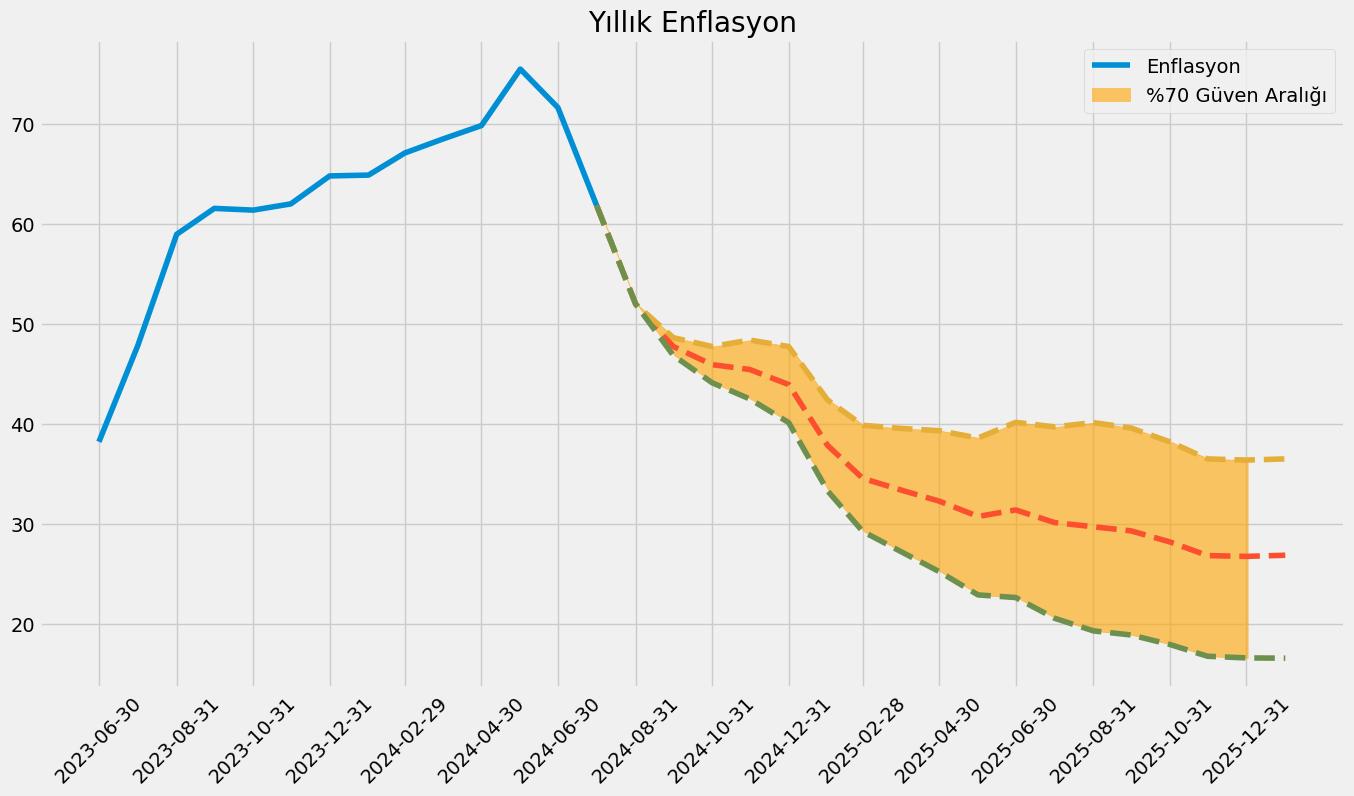

In [172]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.plot(dfas["Ortalama"].loc["2023-06-30":"2024-08-30"],label="Enflasyon")
plt.plot(dfas.loc["2024-07-30":],'--')
plt.fill_between(dfas.loc["2024-07-30":].index.strftime("%Y-%m"), dfas["Max"].loc["2024-07-30":].shift(1), dfas["Min"].loc["2024-07-30":].shift(1), alpha=0.6, color='orange',label="%70 Güven Aralığı")
plt.legend(loc=0)
plt.xticks(dfas.loc["2023-06-30":].index[::2],rotation=45)
plt.title("Yıllık Enflasyon")
plt.show()

In [173]:
sonu12024=str(dfas["Ortalama"].loc["2024-12-31"])[:5]
min2024=str(dfas["Min"].loc["2024-12-31"])[:5]
max2024=str(dfas["Max"].loc["2024-12-31"])[:5]

In [174]:
params = {
    'series': "TP.PKAUO.S01.D.U",
    'startDate': "01-07-2024",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ay12sonra = formatted_response['items']
ay12sonra = pd.DataFrame(ay12sonra)


ay12sonra = ay12sonra.drop(columns=['UNIXTIME','Tarih'])
ay12sonra.columns = ['Beklenti']
ay12sonra['Beklenti'] = pd.to_numeric(ay12sonra['Beklenti'])
ay12sonra=ay12sonra.set_index(pd.date_range(start="2024-07-01",freq="M",periods=len(ay12sonra)))
ay12sonra=ay12sonra.dropna()
ay12sonra

,Beklenti
2024-07-31,42.95


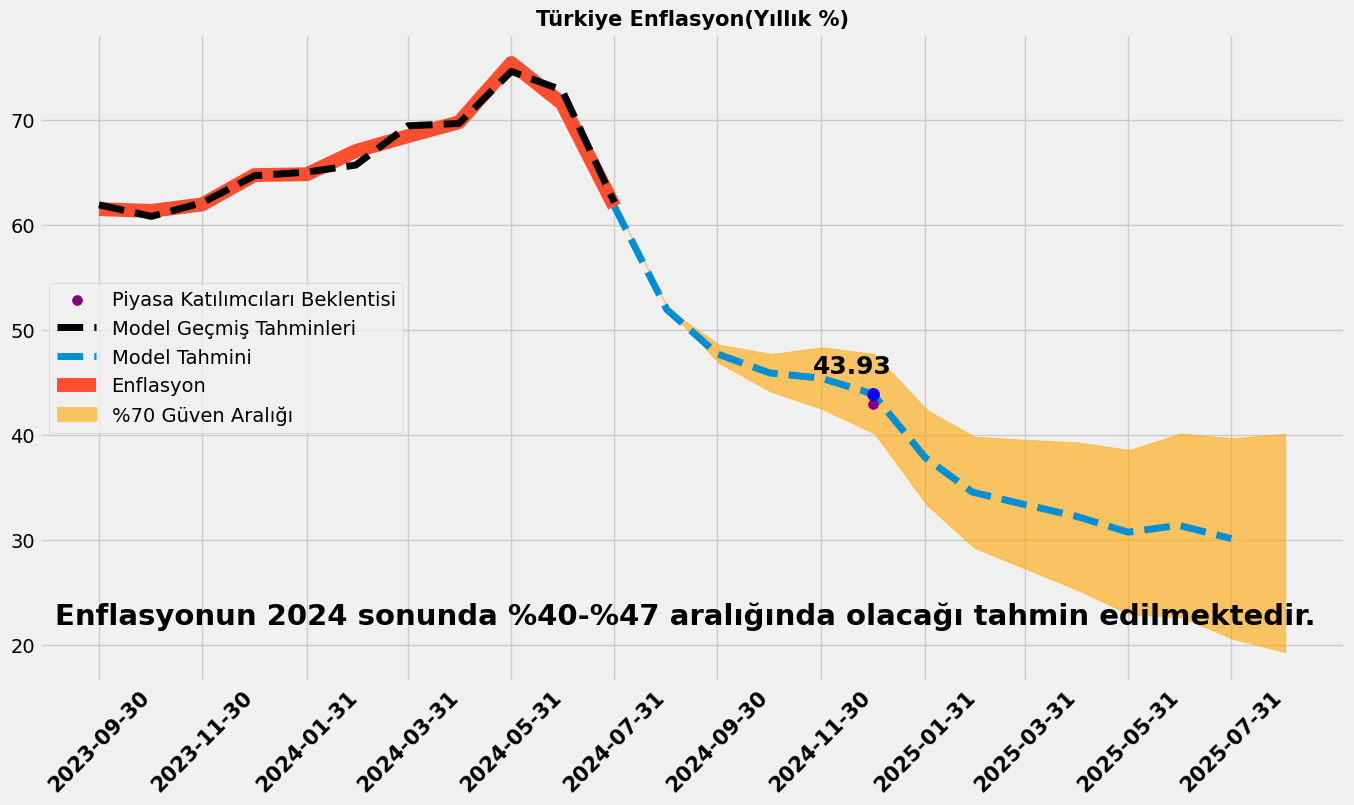

In [182]:
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["Beklenti"].values,color="purple",zorder=3,s=50,label="Piyasa Katılımcıları Beklentisi")
geçmiş=pd.DataFrame({"Tahmin":[61.94,60.84,62.13,64.71,65.06,65.73,69.47,69.69,74.65,72.87,62.17]})
geçmiş=geçmiş.set_index(pd.date_range(start="2023-09-30",periods=len(geçmiş),freq="M"))
plt.plot(geçmiş["Tahmin"],'--',label="Model Geçmiş Tahminleri",color="black",linewidth=5,zorder=3)
plt.scatter(x=dfas.loc["2024-12-31":].index[0],y=dfas["Ortalama"].loc["2024-12-31"],color='blue',zorder=4,s=75)
plt.plot(dfas["Ortalama"].loc["2024-07-30":"2025-08-30"],'--',label="Model Tahmini",linewidth=5)
plt.plot(dfas["Ortalama"].loc["2023-09-30":"2024-08-30"],label="Enflasyon",linewidth=10)
plt.fill_between(dfas.loc["2024-07-30":"2025-09-30"].index.strftime("%Y-%m"), dfas["Max"].loc["2024-07-30":"2025-09-30"].shift(1), dfas["Min"].loc["2024-07-30":"2025-09-30"].shift(1), alpha=0.6, color='orange',label="%70 Güven Aralığı")
annotation_date = mdates.datestr2num('2024-09')
plt.text(mdates.datestr2num('2025-01'), float(sonu12024)+2, sonu12024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 22, f"Enflasyonun 2024 sonunda %{min2024[:2]}-%{max2024[:2]} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='center',fontweight='bold')
plt.xticks(dfas.loc["2023-09-30":"2025-08-30"].index[::2],rotation=45,fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=6)
plt.savefig('forecast.png')
plt.savefig("./forecasts/"+date.today().strftime("%d-%m-%Y")+'.png')
plt.show()

In [110]:
futures.loc["2024-07-31", ["p1min", "p2min", "p3min", "p4min", "p5min"]] = futures.loc["2024-07-31", ["p1", "p2", "p3", "p4", "p5"]].values


In [111]:
modelaylık=futures[[ 'p1min','p2min','p3min','p4min','p5min', 'ortalama']]
modelaylık.columns=["Prophet 1","Prophet 2","Prophet 3","Prophet 4","Prophet 5","Ortalama"]
modelaylık.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/modelaylık.csv')

In [112]:
yıllıktahmin1=dfas[['Ortalama','p1','p2','p3','p4','p5', 'Max',
       'Min']]


yıllıktahmin1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')

In [113]:
yıllıktahmin=pd.read_csv("C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv")
yıllıktahmin=yıllıktahmin.set_index(yıllıktahmin["Unnamed: 0"])
del yıllıktahmin["Unnamed: 0"]
yıllıktahmin=yıllıktahmin.rename_axis(["Tarih"])
yıllıktahmin

,Ortalama,p1,p2,p3,p4,p5,Max,Min
Tarih,,,,,,,,
2007-01-31,9.929595,9.929595,9.929595,9.929595,9.929595,9.929595,9.929595,9.929595
2007-02-28,10.158269,10.158269,10.158269,10.158269,10.158269,10.158269,10.158269,10.158269
2007-03-31,10.863263,10.863263,10.863263,10.863263,10.863263,10.863263,10.863263,10.863263
2007-04-30,10.719962,10.719962,10.719962,10.719962,10.719962,10.719962,10.719962,10.719962
2007-05-31,9.227769,9.227769,9.227769,9.227769,9.227769,9.227769,9.227769,9.227769
...,...,...,...,...,...,...,...,...
2025-08-31,28.681778,27.005736,27.613731,34.396320,28.840514,25.707933,37.409663,22.063116
2025-09-30,28.035207,26.278479,27.019725,33.721054,28.288349,25.025051,36.730365,21.388452
2025-10-31,27.408075,25.553845,26.242813,33.179636,27.792204,24.434581,36.172921,20.750487


In [114]:
dfas.tail(18)

,Ortalama,Max,Min,p1,p2,p3,p4,p5
2024-07-31,61.762930,61.809564,60.659980,60.915317,60.960765,61.058040,61.249598,60.659980
2024-08-31,50.994477,51.869637,49.647989,50.189925,50.224896,50.644900,50.558930,49.647989
2024-09-30,47.220980,48.969013,45.616121,46.327823,46.225011,47.594835,46.730972,45.616121
2024-10-31,45.274971,47.768262,43.222048,44.202422,44.315440,46.239508,44.701900,43.359643
2024-11-30,43.421510,46.658210,40.911331,42.200495,42.669682,44.646710,42.813010,41.272405
2024-12-31,42.479215,46.601894,39.151255,40.994733,41.573679,44.500648,41.890332,39.970069
2025-01-31,38.502690,43.296840,34.383613,36.633458,37.361390,41.246960,38.054756,35.867087
2025-02-28,35.181395,40.483121,30.692585,33.329743,33.831380,38.234569,34.838173,32.416675
2025-03-31,33.635793,39.683946,28.610714,31.719510,32.059742,37.282486,33.264040,30.656711
2025-04-30,32.213937,39.033018,26.358585,30.033682,30.643425,36.694694,31.715490,28.857088


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '2023-09'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-11'),
  Text(3, 0, '2023-12'),
  Text(4, 0, '2024-01'),
  Text(5, 0, '2024-02'),
  Text(6, 0, '2024-03'),
  Text(7, 0, '2024-04'),
  Text(8, 0, '2024-05'),
  Text(9, 0, '2024-06'),
  Text(10, 0, '2024-07')])

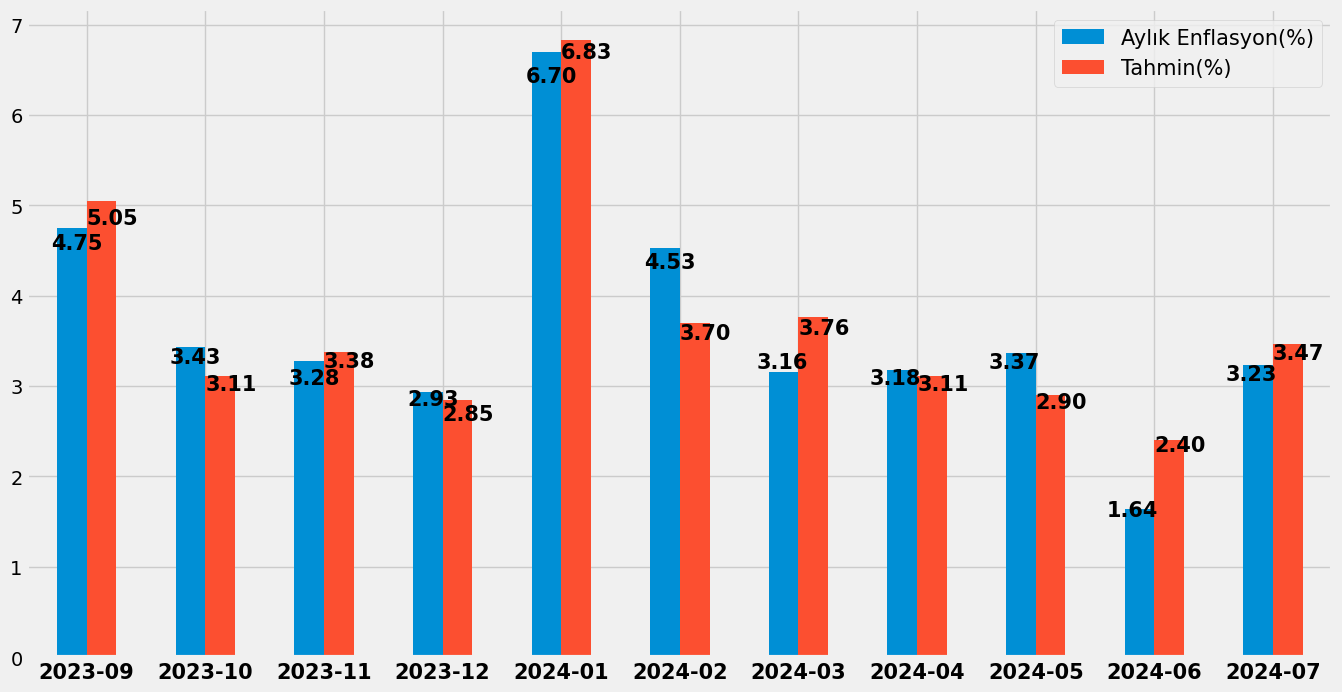

In [8]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28,2.93,6.70,4.53,3.16,3.18,3.37,1.64,3.23],"Tahmin(%)":[5.05,3.11,3.38,2.85,6.83,3.70,3.76,3.11,2.90,2.40,3.47]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=11,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar",figsize=(15,8))
plt.annotate("4.75",xy=(-0.3,gecmis.iloc[0,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("5.05",xy=(0,gecmis.iloc[0,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.43",xy=(0.7,gecmis.iloc[1,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(1,gecmis.iloc[1,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.28",xy=(1.7,gecmis.iloc[2,0]*0.92),fontweight="bold",fontsize=15)
plt.annotate("3.38",xy=(2,gecmis.iloc[2,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.93",xy=(2.7,gecmis.iloc[3,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.85",xy=(3,gecmis.iloc[3,1]*0.92),fontweight="bold",fontsize=15)
plt.annotate("6.70",xy=(3.7,gecmis.iloc[4,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.83",xy=(4,gecmis.iloc[4,1]*0.97),fontweight="bold",fontsize=15)
plt.annotate("4.53",xy=(4.7,gecmis.iloc[5,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.70",xy=(5,gecmis.iloc[5,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.16",xy=(5.65,gecmis.iloc[6,1]*0.85),fontweight="bold",fontsize=15)
plt.annotate("3.76",xy=(6,gecmis.iloc[6,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.18",xy=(6.6,gecmis.iloc[7,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(7,gecmis.iloc[7,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.37",xy=(7.6,gecmis.iloc[8,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.90",xy=(8,gecmis.iloc[8,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("1.64",xy=(8.6,gecmis.iloc[9,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.40",xy=(9,gecmis.iloc[9,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.23",xy=(9.6,gecmis.iloc[10,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.47",xy=(10,gecmis.iloc[10,1]*0.95),fontweight="bold",fontsize=15)

plt.legend(fontsize=15)
plt.xticks(rotation=0,fontweight="bold",fontsize=15,color="black")

In [115]:
aylıktahmin=modelaylık["Ortalama"]
aylıktahmin=aylıktahmin.loc[:"2025-07-31"]

Text(11.75, 1.7079183265370668, '1.79')

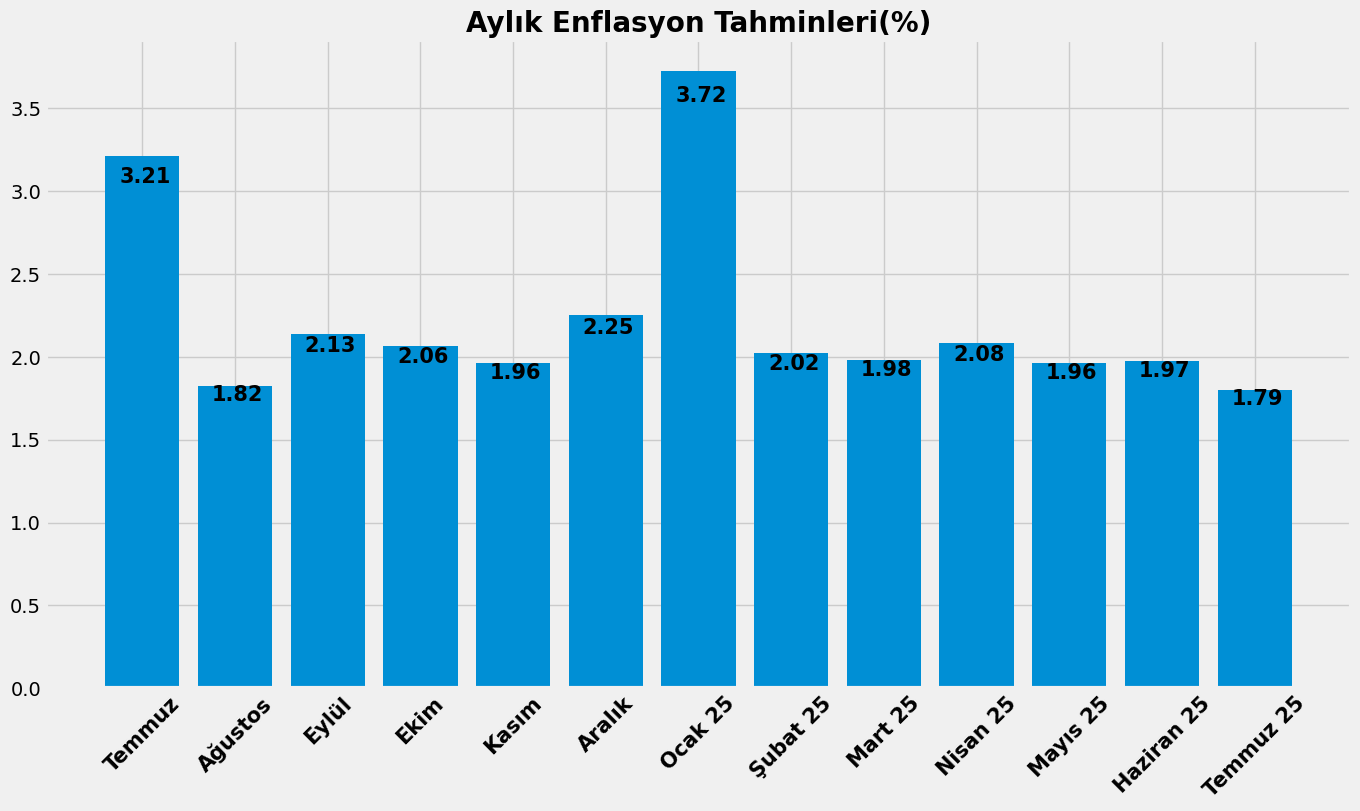

In [116]:
plt.figure(figsize=(15,8))
plt.bar(x=["Temmuz","Ağustos","Eylül","Ekim","Kasım","Aralık","Ocak 25","Şubat 25","Mart 25","Nisan 25","Mayıs 25","Haziran 25","Temmuz 25"],height=aylıktahmin.values)
plt.xticks(rotation=45,fontweight="bold",color="black",fontsize=15)
plt.title("Aylık Enflasyon Tahminleri(%)",fontweight="bold",fontsize=20)
plt.annotate(str(aylıktahmin.iloc[0])[:4],xy=(-0.25,aylıktahmin.iloc[0]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[1])[:4],xy=(0.75,aylıktahmin.iloc[1]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[2])[:4],xy=(1.75,aylıktahmin.iloc[2]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[3])[:4],xy=(2.75,aylıktahmin.iloc[3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[4])[:4],xy=(3.75,aylıktahmin.iloc[4]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[5])[:4],xy=(4.75,aylıktahmin.iloc[5]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[6])[:4],xy=(5.75,aylıktahmin.iloc[6]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[7])[:4],xy=(6.75,aylıktahmin.iloc[7]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[8])[:4],xy=(7.75,aylıktahmin.iloc[8]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[9])[:4],xy=(8.75,aylıktahmin.iloc[9]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[10])[:4],xy=(9.75,aylıktahmin.iloc[10]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[11])[:4],xy=(10.75,aylıktahmin.iloc[11]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[12])[:4],xy=(11.75,aylıktahmin.iloc[12]*0.95),fontweight="bold",fontsize=15)



